# Neural Networks
 

<font color="blue"> Mahalavanya Sriram </font>

# Overview

The primary objective of this workbook is to learn and implement the neural networks. From this work book we will get a complete understanding of the structure of neural networks, how it works, what are the important parameters that can affect our outputs and most crucially how to calculate the weights of all the layers(one hidden and output layer in our case).

For Neural Networks implementation, we will be implementing two algorithms:

- Non-Linear Regression
- Non-Linear Logistic Regression

Apart from just implementing neural networks, we will be implementing a regularization technique which is Cross Validation to deal with the problem of Underfitting and Overfitting. In this part we will also tune our model with different set of hyperparameters for all validation and test sets and come up with the best set of parameters according to the score calculated each time we run our model.

# Data

## Regression (Bike sharing demand)

This dataset is about Bike sharing systems. They are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated throughout a city. Using these systems, people can rent a bike from a one location and return it to a different place on an as-needed basis. This dataset combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C. The data is provided hourly rental data spanning two years(2011-2012). Training set consits of data for first 19 days of a month and test set consits of rest of the days.

### Data Attributes
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius.The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp - "feels like" temperature in Celsius. TThe values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- humidity - relative humidity. The values are divided to 100 (max)
- windspeed - wind speed. The values are divided to 67 (max)
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)


In [1]:
#loading the required packages
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import math
from nn import NeuralNet
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, accuracy_score, f1_score

### Data Visualizations

In [2]:
# Importing all the datasets required
bike_sharing_data = pd.read_csv("data/bike_sharing_demand.csv")
bike_sharing_data = bike_sharing_data.loc[:, ~bike_sharing_data.columns.str.contains('^Unnamed')]

#### Data description

In [3]:
# Checking for the number of rows and columns in a dataset.
bike_sharing_data.shape

(17379, 12)

In [4]:
#Checking the attributes in the dataset
bike_sharing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  float64
 8   windspeed   17379 non-null  float64
 9   casual      17379 non-null  int64  
 10  registered  17379 non-null  int64  
 11  count       17379 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 1.6+ MB


In [5]:
# display all the columns
pd.options.display.max_columns = None
# the top 5 rows of the dataset
bike_sharing_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
# checking the statistical summary of the dataset 
bike_sharing_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.028770,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.167165,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,0.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Data Cleaning
##### looking for missing values in the dataset

In [7]:
#Check for nulls in the dataset and count for the number of nulls
bike_sharing_data.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No Missing values are found in the dataset

##### Feature engineering for better visualisation
Splitting the datetime column into date, month, hour and weekday makes our data analysis much efficient. By this we will be able to visualize the bike rental count for each day of the week, specific month and a specfic time of the day.

changing the categorical variables such as month, season, holiday, etc. to the categorical type.

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

- Create new columns "date,"hour","weekDay","month" from "datetime" column.
- Coerce the datatype of "season","holiday","workingday" and weather to category.
- Drop the datetime column as we already extracted useful features from it.

In [8]:
#spliting the data time field for better visualizations
bike_sharing_data["date"] = bike_sharing_data.datetime.apply(lambda x : x.split()[0])
bike_sharing_data["hour"] = bike_sharing_data.datetime.apply(lambda x : x.split()[1].split(":")[0])
bike_sharing_data["weekday"] = bike_sharing_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
bike_sharing_data["month"] = bike_sharing_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

In [9]:
#changin appropriate variable type
categoricalVariables = ["weekday","month","season","weather","holiday","workingday"]
for var in categoricalVariables:
    bike_sharing_data[var] = bike_sharing_data[var].astype("category")

In [10]:
bike_sharing_data["month"] = bike_sharing_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
bike_sharing_data["season"] = bike_sharing_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
bike_sharing_data["weather"] = bike_sharing_data.weather.map({1: "Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist", \
                                        3 : "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 : "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog" })

In [11]:
bike_sharing_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01,04,Saturday,January


In [12]:
bike_sharing_data.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
hour            object
weekday       category
month           object
dtype: object

#### Plots for understanding or analysis

##### Correlation

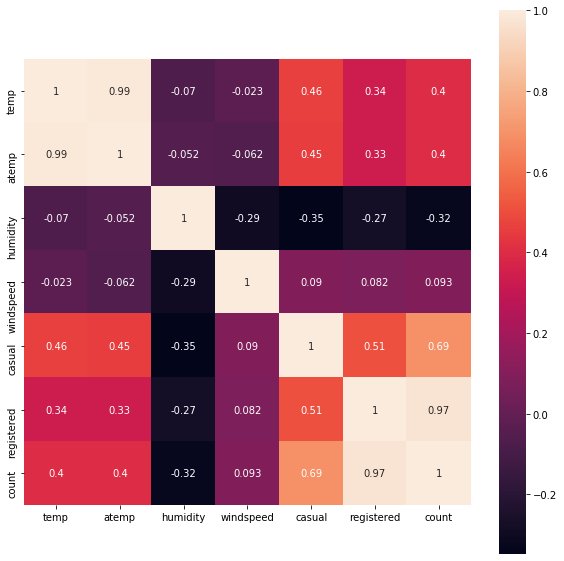

In [13]:
correlation = bike_sharing_data.corr()
mask = np.array(correlation)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(correlation, annot = True, square = True)

From the above correlation matrix we can observe the following,
- temp and atemp are highly correlated (hence both can be considered the same). hence We can drop one of the features to avoid the colinearity during prediction
- temp (includes atemp) has got high correlation to the casual, registered and count 
- humidity and windspeed are not that correlated to count, infact humidity is negatively correlated

##### Outliers

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

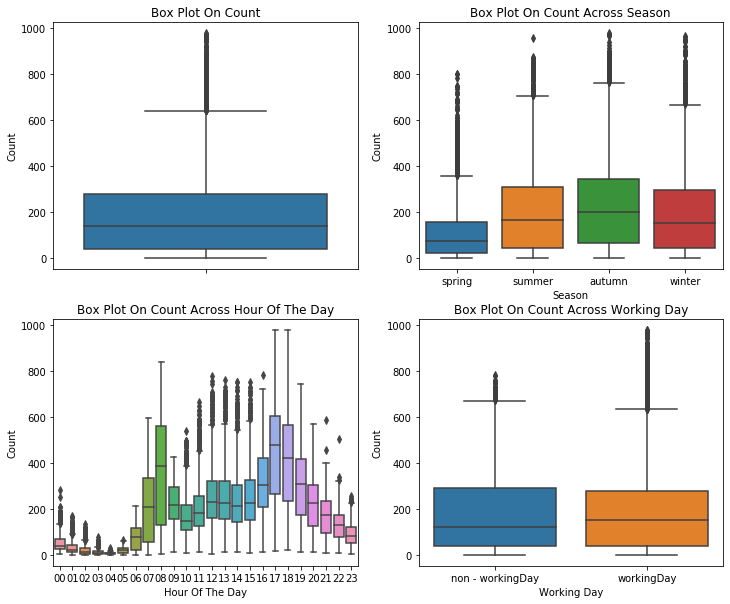

In [14]:
 season_names = ["spring", "summer", "autumn", "winter"]
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=bike_sharing_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=bike_sharing_data,y="count",x="season",orient="v",ax=axes[0][1])
axes[0][1].set_xticklabels(season_names)
sns.boxplot(data=bike_sharing_data,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=bike_sharing_data,y="count",x="workingday",orient="v",ax=axes[1][1])
axes[1][1].set_xticklabels(["non - workingDay","workingDay"])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")


- "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).
- Spring season has got relatively lower count which can be seen from dip in the box plot median
- From 3rd figure we can see that the median of count from 7am - 9am and 5pm - 7pm is large as its the before and afterworking hours where people uses bicycles for commute to and from office, schools etc.
- Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from figure 4.

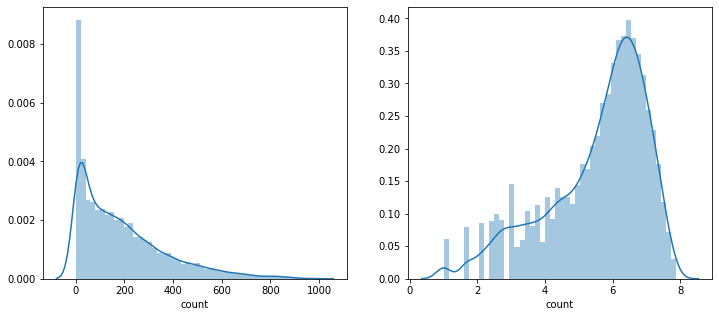

In [15]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12,5)
sns.distplot(bike_sharing_data['count'], ax=ax1)
sns.distplot(np.log(bike_sharing_data['count'])+1, ax=ax2)

#### Data Visualizations

[Text(0, 0, 'non-holiday'), Text(0, 0, 'holiday')]

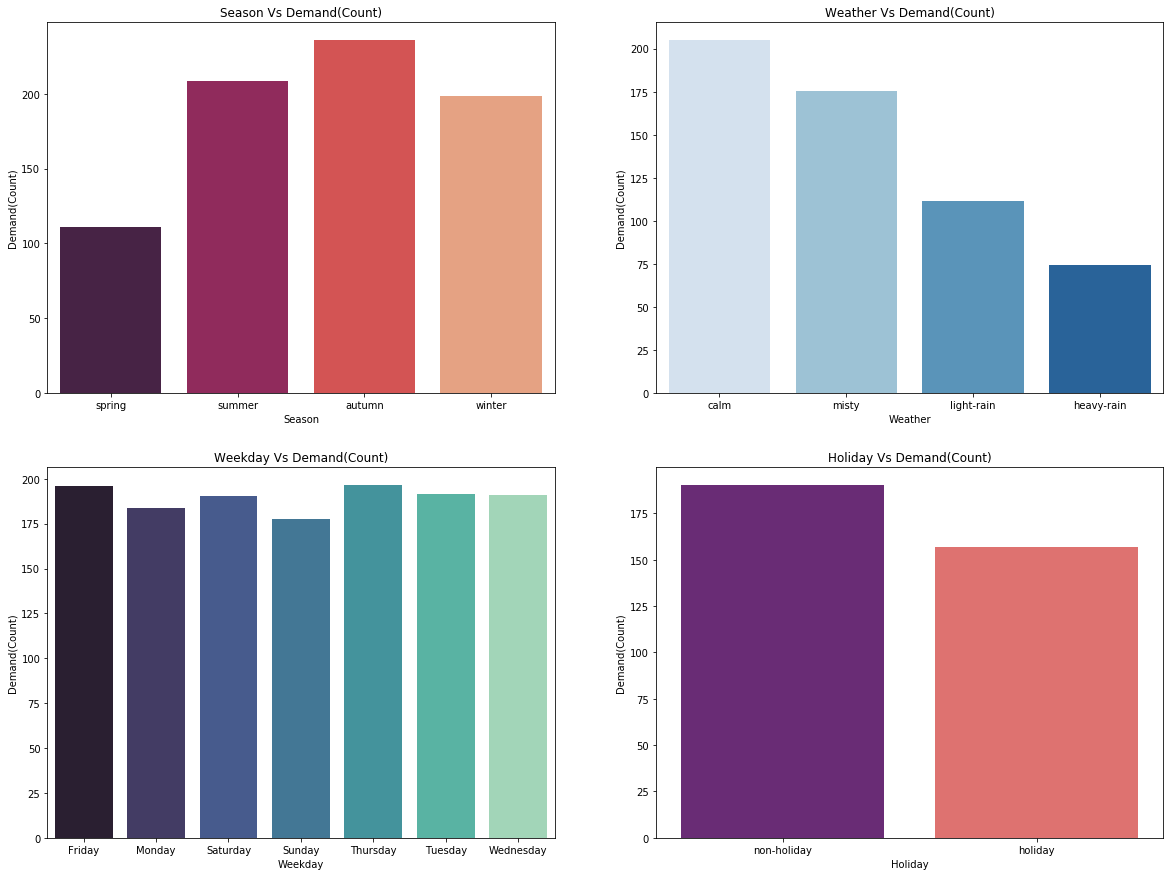

In [16]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 15)
season_names = ["spring", "summer", "autumn", "winter"]
weather_names = ["calm", "misty", "light-rain", "heavy-rain"]
sns.barplot(data=bike_sharing_data, x='season',y='count',ax=axes[0][0], palette="rocket", ci = 0)
axes[0][0].set(xlabel='Season', ylabel='Demand(Count)',title = 'Season Vs Demand(Count)')
axes[0][0].set_xticklabels(season_names)
sns.barplot(data=bike_sharing_data, x='weather',y='count',ax=axes[0][1], palette="Blues", ci = 0)
axes[0][1].set(xlabel='Weather', ylabel='Demand(Count)',title = 'Weather Vs Demand(Count)')
axes[0][1].set_xticklabels(weather_names)
sns.barplot(data=bike_sharing_data, x='weekday',y='count',ax=axes[1][0], palette="mako", ci = 0)
axes[1][0].set(xlabel='Weekday', ylabel='Demand(Count)',title = 'Weekday Vs Demand(Count)')
sns.barplot(data=bike_sharing_data, x='holiday',y='count',ax=axes[1][1], palette="magma", ci = 0)
axes[1][1].set(xlabel='Holiday', ylabel='Demand(Count)',title = 'Holiday Vs Demand(Count)')
axes[1][1].set_xticklabels(["non-holiday","holiday"])

Observations made from above visualizations are these mentioned below
- As seen from box plot the count of bikes in spring is very low compared to other seasons
- the count is relatively less both in rainy and stromy weathers
- the count is slightly higher for a saturday and thursday
- the count remains almost same for a holiday and a non holiday  

[Text(0, 0.5, 'Demand(Count)'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Demand(Count) By Hour Of The Day Across User Type'),
 None]

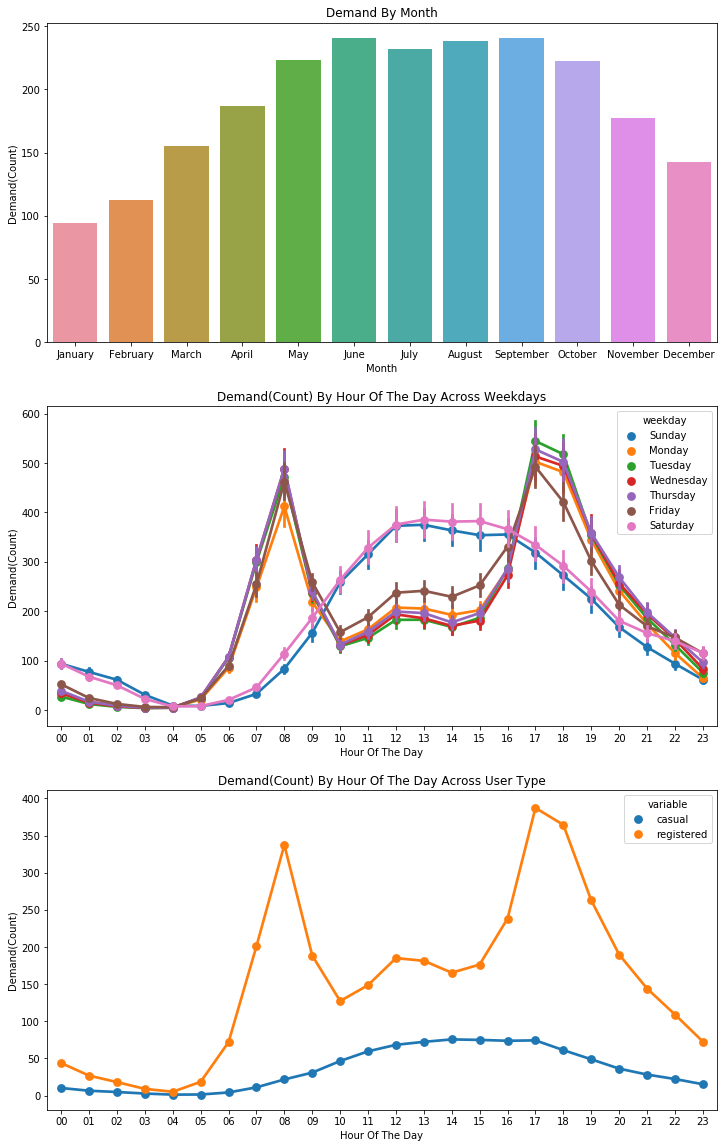

In [17]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)
hue = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
monthSort = ["January","February","March","April","May","June","July","August","September","October","November","December"]

sns.barplot(data=bike_sharing_data,x="month",y="count",ax=ax1,order=monthSort, ci = 0)
ax1.set(xlabel='Month', ylabel='Demand(Count)',title="Demand By Month")

sns.pointplot(x="hour", y="count",hue=bike_sharing_data["weekday"],hue_order=hue, data=bike_sharing_data, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Demand(Count)',title="Demand(Count) By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(bike_sharing_data[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Demand(Count)',title="Demand(Count) By Hour Of The Day Across User Type",label='big')


Above are visualizations of Count Vs (Month,Hour,Weekday,Usertype)
- The demand is plotted month wise and may to october are peak months for such bike rentals (basically fall season).
- Further these line plots gives us information of the demand every hour of the day categorised separately by weekdays and usertype
    - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
    - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
    - The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.


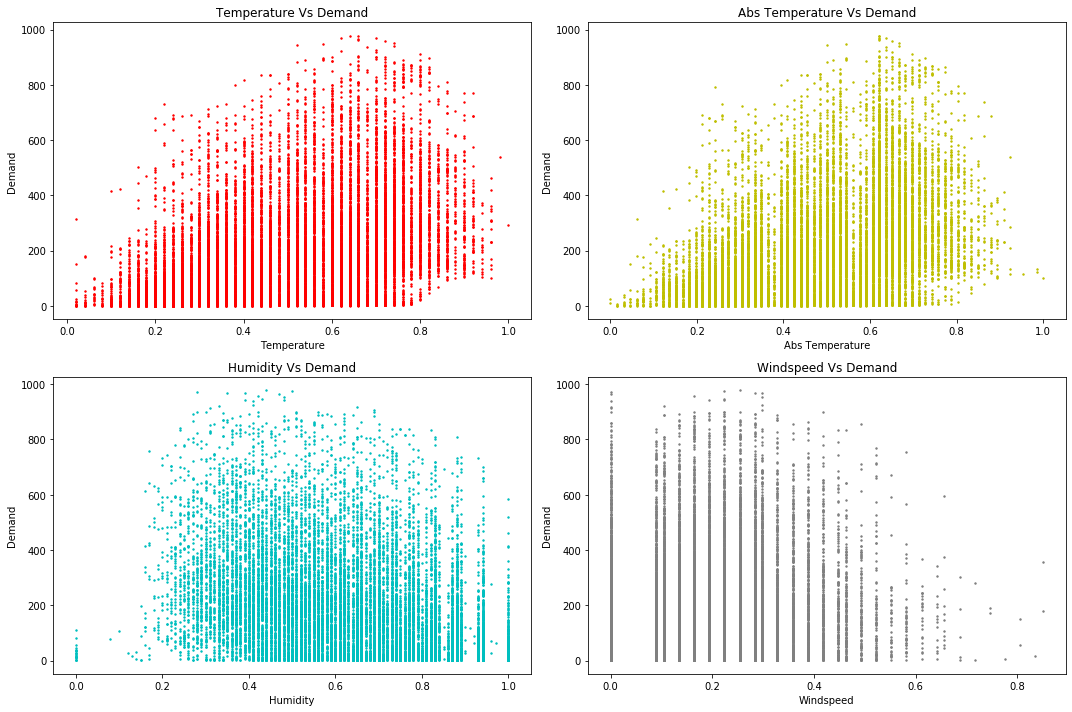

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1,)
plt.title('Temperature Vs Demand')
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.scatter(bike_sharing_data['temp'],bike_sharing_data['count'],s=2,c='r')

plt.subplot(2,2,2)
plt.title('Abs Temperature Vs Demand')
plt.xlabel('Abs Temperature')
plt.ylabel('Demand')
plt.scatter(bike_sharing_data['atemp'],bike_sharing_data['count'],s=2,c='y')

plt.subplot(2,2,3)
plt.title('Humidity Vs Demand')
plt.xlabel('Humidity')
plt.ylabel('Demand')
plt.scatter(bike_sharing_data['humidity'],bike_sharing_data['count'],s=2,c='c')

plt.subplot(2,2,4)
plt.title('Windspeed Vs Demand')
plt.xlabel('Windspeed')
plt.ylabel('Demand')
plt.scatter(bike_sharing_data['windspeed'],bike_sharing_data['count'],s=2,c='grey')

plt.tight_layout()

Its evident from above plots that temperature and Windspeed have an affect on Bike demand and also effect of temp and atemp are very similar as they both are almost the same as we had seen in corellation


#### Preprocessing of the data

##### Feature Engineering
Now most importantly split the date and time as the time of day is expected to effect the no of bikes. for eg at office hours like early mornning or evening one would expect a greater demand of rental bikes. The year is also coded for better prediction

In [19]:
bike_sharing_data["date"] = bike_sharing_data.datetime.apply(lambda x : x.split()[0])
bike_sharing_data["hour"] = [t.hour for t in pd.DatetimeIndex(bike_sharing_data.datetime)]
bike_sharing_data['year'] = [t.year for t in pd.DatetimeIndex(bike_sharing_data.datetime)]
bike_sharing_data['year'] = bike_sharing_data['year'].map({2011:0, 2012:1})
bike_sharing_data['year'] = bike_sharing_data['year'].astype("category")

# now we can drop the datetime column
bike_sharing_data.drop('datetime',axis=1,inplace=True)

##### Removing outliers
The outliers of the target column found from the box plot in data visualization is removed

In [20]:
bike_sharing_data = bike_sharing_data[np.abs(bike_sharing_data["count"]-bike_sharing_data["count"].mean())<=(3*bike_sharing_data["count"].std())] 
bike_sharing_data.shape


(17135, 16)

##### Encoding
All the categorical variables are one hot encoded where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [21]:
season=pd.get_dummies(bike_sharing_data['season'])
bike_sharing_data=pd.concat([bike_sharing_data,season],axis=1)
weather=pd.get_dummies(bike_sharing_data['weather'])
bike_sharing_data=pd.concat([bike_sharing_data,weather],axis=1)
weekday=pd.get_dummies(bike_sharing_data['weekday'])
bike_sharing_data=pd.concat([bike_sharing_data,weekday],axis=1)
month=pd.get_dummies(bike_sharing_data['month'])
bike_sharing_data=pd.concat([bike_sharing_data,month],axis=1)
hour=pd.get_dummies(bike_sharing_data['hour'],prefix = 'hour')
bike_sharing_data=pd.concat([bike_sharing_data,hour],axis=1)

In [22]:
bike_sharing_data.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
                ...   
hour_19          uint8
hour_20          uint8
hour_21          uint8
hour_22          uint8
hour_23          uint8
Length: 67, dtype: object

##### Dropping columns that are not related to the target variable
The column both casual and registered are dropped and other original column of the encoded variables are dropped too.

In [23]:
bike_sharing_data.drop(['casual','registered','season','weather','weekday','month','hour','date', 'year','atemp','workingday','holiday','humidity'],axis=1,inplace=True)
bike_sharing_data.shape

(17135, 54)

### Preliminary observation 

We used certain libraries to pre process our dataset. We had to split the date column for better visualization and understanding of the dataset. Through different visualization we were able to conclude that one paricular attribute had no effect on the target variable. We found no missing data in our dataset. But we obsereved that the target variable is highly skewed. count variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).Hence, We took log transformation on target variable after removing outlier data points. After tranformation the data looked better but still was not ideal. From the detailed understanding and visualization of the dataset, the following observations are derieved
- By plotting correlation matrix we were able to conclude Temperature and Absolute temperature plots are alsmost similar in nature
- Demand of bike depend mainly on temperature and windspeed. It also depends on the season. Warm climate attracts more users.  For Higher the windspeed the demand is very low. Most of bike in autum season than other seasons as the weather conditions are warm and pleasent
- Demand remains the same on working day and a holiday as the registered users are more on a workingday and less on a holiday but is compensated by more casual users
- All days of the week are busy. But casual users are more on saturday and sunday whereas registered users are more on weekdays
- Peak hours are
- Humidity doesnot have an effect on the bike demand



## Classification (Forest cover type)

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.hese areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

You must predict the Cover_Type for every row in the test set (565892 observations).

## Data Attributes
The dataset has 54 features and 1 target variable 'Cover_Type'. From 54 features, 10 are numeric and 44 are catrgorical. From 44 categorical, 40 are of Soil_Type and 4 of Wilderness_Area.

1. Elevation - Elevation in meters
2. Aspect - Aspect in degrees azimuth
3. Slope - Slope in degrees
4. Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
5. Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
6. Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
7. Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
8. Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
9. Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
10. Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
11. Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
12. Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
13. Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The wilderness areas are:

1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

The soil types are:

1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.
6. Vanet - Wetmore families - Rock outcrop complex, stony.
7. Gothic family.
8. Supervisor - Limber families complex.
9. Troutville family, very stony.
10. Bullwark - Catamount families - Rock outcrop complex, rubbly.
11. Bullwark - Catamount families - Rock land complex, rubbly.
12. Legault family - Rock land complex, stony.
13. Catamount family - Rock land - Bullwark family complex, rubbly.
14. Pachic Argiborolis - Aquolis complex.
15. unspecified in the USFS Soil and ELU Survey.
16. Cryaquolis - Cryoborolis complex.
17. Gateview family - Cryaquolis complex.
18. Rogert family, very stony.
19. Typic Cryaquolis - Borohemists complex.
20. Typic Cryaquepts - Typic Cryaquolls complex.
21. Typic Cryaquolls - Leighcan family, till substratum complex.
22. Leighcan family, till substratum, extremely bouldery.
23. Leighcan family, till substratum - Typic Cryaquolls complex.
24. Leighcan family, extremely stony.
25. Leighcan family, warm, extremely stony.
26. Granile - Catamount families complex, very stony.
27. Leighcan family, warm - Rock outcrop complex, extremely stony.
28. Leighcan family - Rock outcrop complex, extremely stony.
29. Como - Legault families complex, extremely stony.
30. Como family - Rock land - Legault family complex, extremely stony.
31. Leighcan - Catamount families complex, extremely stony.
32. Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33. Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34. Cryorthents - Rock land complex, extremely stony.
35. Cryumbrepts - Rock outcrop - Cryaquepts complex.
36. Bross family - Rock land - Cryumbrepts complex, extremely stony.
37. Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38. Leighcan - Moran families - Cryaquolls complex, extremely stony.
39. Moran family - Cryorthents - Leighcan family complex, extremely stony.
40. Moran family - Cryorthents - Rock land complex, extremely stony.

### Data Visualizations

In [24]:
# Importing all the datasets required
forest_covtype_data = pd.read_csv("data/covtype.csv")

#### Data description

In [25]:
# Checking for the number of rows and columns in a dataset.
forest_covtype_data.shape

(581012, 55)

In [26]:
#Checking the attributes in the dataset
forest_covtype_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [27]:
# display all the columns
pd.options.display.max_columns = None
# the top 5 rows of the dataset
forest_covtype_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [28]:
# checking the statistical summary of the dataset 
forest_covtype_data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

#### Data Cleaning and Pre-processing
##### looking for missing values in the dataset

In [29]:
#Check for nulls in the dataset and count for the number of nulls
forest_covtype_data.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


No Missing values are found in the dataset

##### Down Sampling Data

In [30]:
forest_covtype_data = forest_covtype_data.sample(n= 25000)

The above code is just taking random 20000 sample from the dataset because our initial dataset has very large number of samples (more than half a million). So we just sample out the data in order to reduce the computation time.



In [31]:
# Resetting the index for our sampled dataset
forest_covtype_data = forest_covtype_data.reset_index(drop=True)

In [32]:
forest_covtype_data.shape

(25000, 55)

##### Skewness

If the skewness is equal to zero,data is perfectly symmetrical. If skewness is positive, the data are positively skewed or skewed right. If skewness is negative, the data are negatively skewed or skewed left.

In [33]:
# analysing the skewness 
forest_covtype_data.skew()

Elevation                             -0.794997
Aspect                                 0.379165
Slope                                  0.795671
Horizontal_Distance_To_Hydrology       1.141857
Vertical_Distance_To_Hydrology         1.730014
Horizontal_Distance_To_Roadways        0.721017
Hillshade_9am                         -1.146147
Hillshade_Noon                        -1.056245
Hillshade_3pm                         -0.263561
Horizontal_Distance_To_Fire_Points     1.289205
Wilderness_Area1                       0.220542
Wilderness_Area2                       4.054161
Wilderness_Area3                       0.250435
Wilderness_Area4                       3.518610
Soil_Type1                            13.601378
Soil_Type2                             8.948647
Soil_Type3                            10.990224
Soil_Type4                             6.588584
Soil_Type5                            19.689441
Soil_Type6                             8.783513
Soil_Type7                            64

We can see that many are positively skewed and Soil_Type 8 and Soil_Type 25 are highly positively skewed.
Hillshade data are negatively skewed.

##### Target Data Distribution

In [34]:
print(forest_covtype_data['Cover_Type'].value_counts())

2    12251
1     8951
3     1562
7      930
6      766
5      414
4      126
Name: Cover_Type, dtype: int64


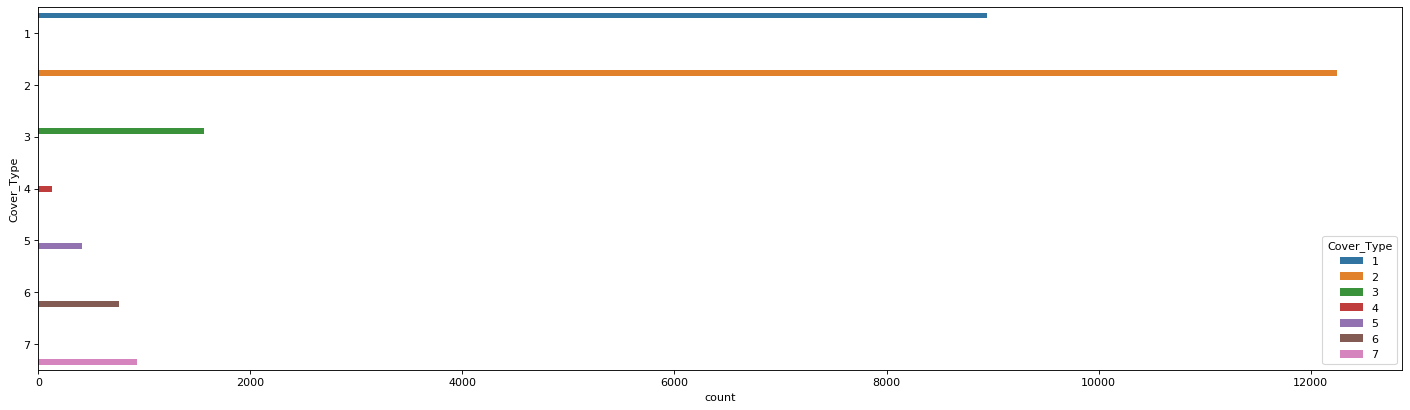

In [35]:
plt.figure(figsize=(22,6), dpi= 80)
ax = sns.countplot(y=forest_covtype_data["Cover_Type"], hue="Cover_Type", data=forest_covtype_data)

The target data is not equally distributed across the cover types

##### Correlation

In [36]:
corr = forest_covtype_data.corr()

In [37]:
corr['Cover_Type'].sort_values(ascending = False)

Cover_Type                            1.000000
Wilderness_Area4                      0.316390
Soil_Type10                           0.240408
Soil_Type39                           0.156169
Soil_Type38                           0.156140
Slope                                 0.145235
Soil_Type40                           0.129516
Soil_Type2                            0.113223
Soil_Type6                            0.111794
Soil_Type35                           0.100241
Soil_Type17                           0.095008
Soil_Type4                            0.092351
Soil_Type1                            0.091391
Vertical_Distance_To_Hydrology        0.090334
Soil_Type37                           0.085269
Soil_Type5                            0.078463
Soil_Type3                            0.066049
Wilderness_Area3                      0.064887
Soil_Type14                           0.060049
Soil_Type11                           0.025295
Soil_Type36                           0.021686
Soil_Type13  

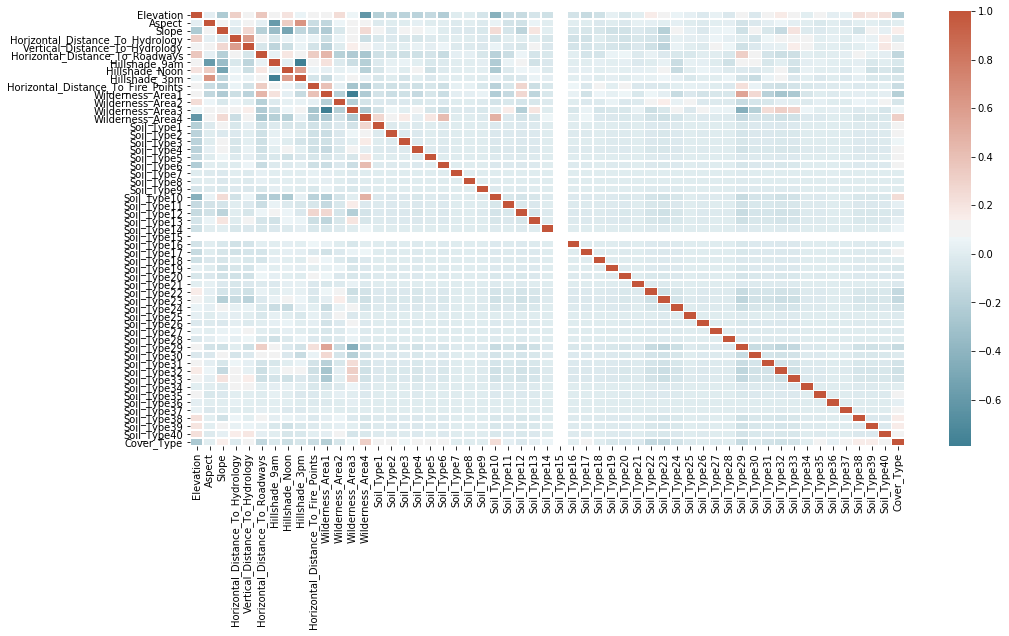

In [38]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)  
plt.figure(figsize = (16,8)) 
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, linewidths=.5)

Analysing the above heatmap the following relations were highly corellated
- Elevation and Horizontal Distance to Roadways.
- Aspect and Hillshade at 9am
- Aspect and Hillshade at 3pm
- Slope and Hillshade at Noon
- Horizontal Distance to hydrology and Vertical Distance to Hydrology
- Hillshade at 9am and Hillshade at 3pm
- Hillshade at 3pm and Hillshade at Noon

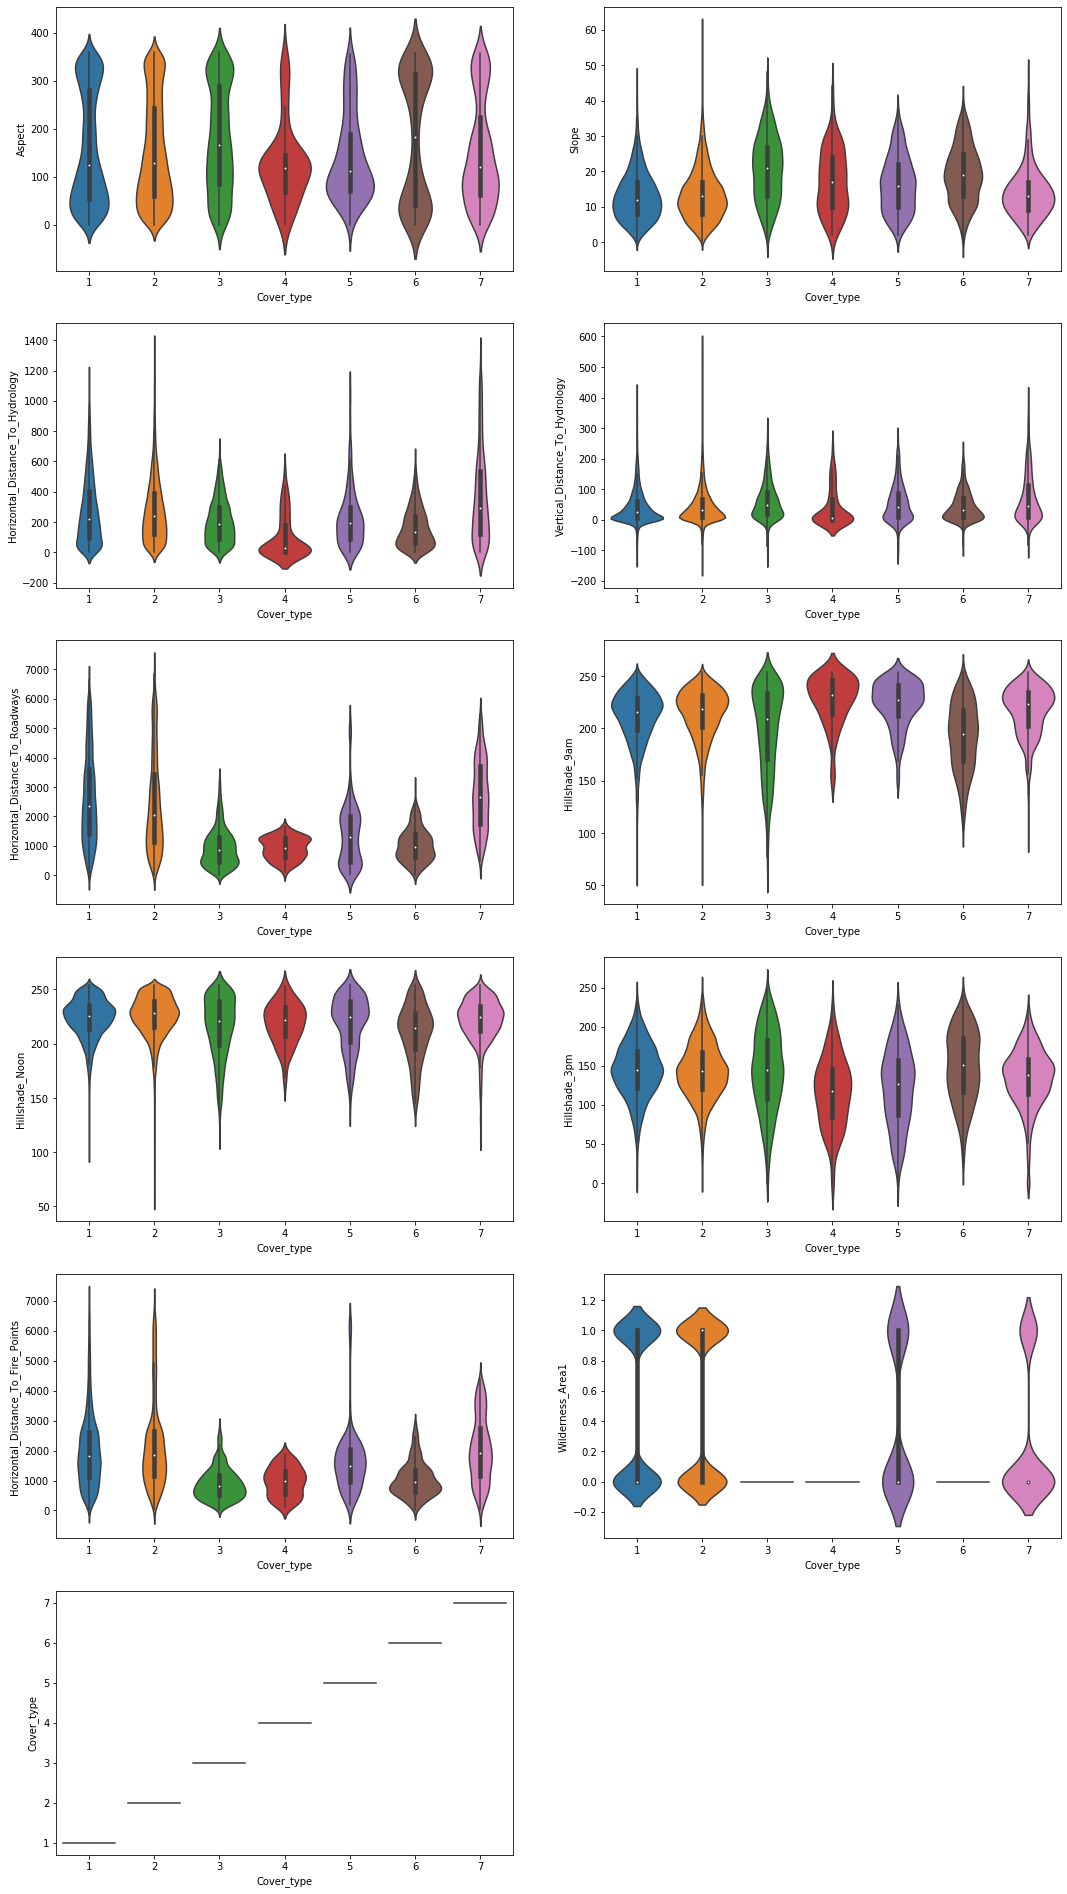

In [39]:
forest_covtype_data_cont = forest_covtype_data.iloc[:,1:11].copy()
 
forest_covtype_data_cont['Cover_type'] = forest_covtype_data.Cover_Type 
fig = plt.figure()
fig.set_figheight(34)
fig.set_figwidth(18)

for i, item in enumerate(forest_covtype_data_cont.columns.to_list()):
    fig.add_subplot(math.ceil(len(forest_covtype_data_cont.columns.to_list())/2), 2, i+1)
    sns.violinplot(y= item, x = 'Cover_type', data = forest_covtype_data_cont)

# plt.savefig('Graph/Bivariate_feat_cover.jpg')
plt.show()

[Text(0, 0, 'Rawah Wilderness Area'),
 Text(0, 0, 'Neota Wilderness Area'),
 Text(0, 0, 'Comanche Peak Wilderness Area'),
 Text(0, 0, 'Cache la Poudre Wilderness Area')]

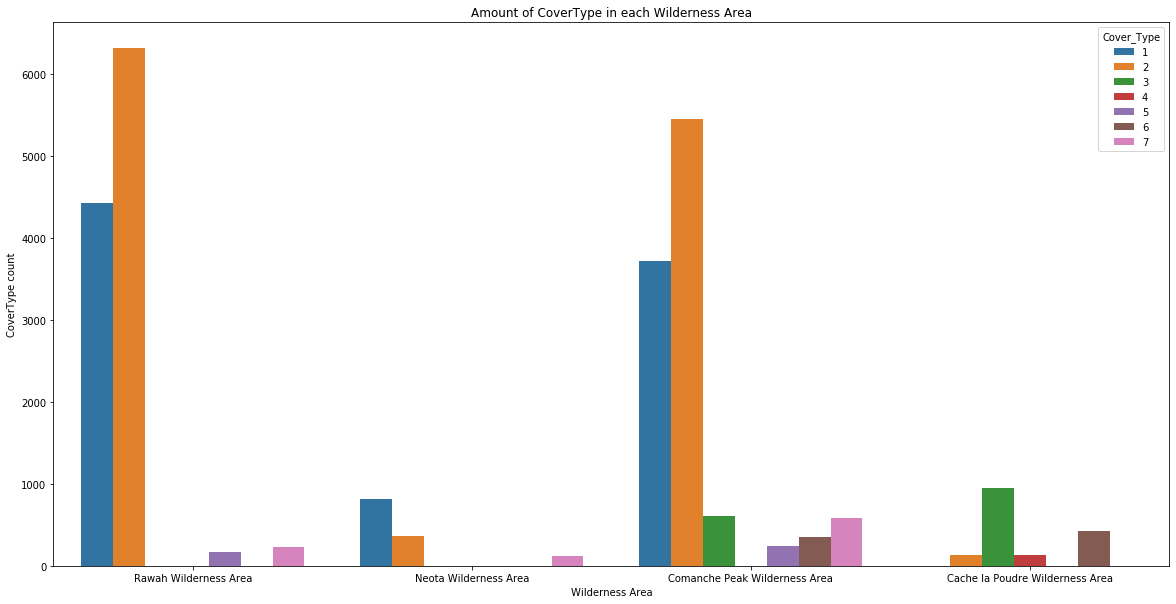

In [40]:
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
dataTransformed = pd.melt(forest_covtype_data[["Cover_Type",'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']], id_vars=['Cover_Type'], value_vars=['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'])
dataAggregated = pd.DataFrame(dataTransformed.groupby(["Cover_Type","variable"],sort=True)["value"].sum()).reset_index()
sns.barplot(x=dataAggregated["variable"], y=dataAggregated["value"],hue=dataAggregated["Cover_Type"], data = dataAggregated)
ax.set(xlabel='Wilderness Area', ylabel='CoverType count',title = 'Amount of CoverType in each Wilderness Area', label='big')
ax.set_xticklabels(["Rawah Wilderness Area","Neota Wilderness Area","Comanche Peak Wilderness Area","Cache la Poudre Wilderness Area"])


Wilderness Area Rawah and "Comanche Peak seem to be good discrminators of the cover types (distinct classes).


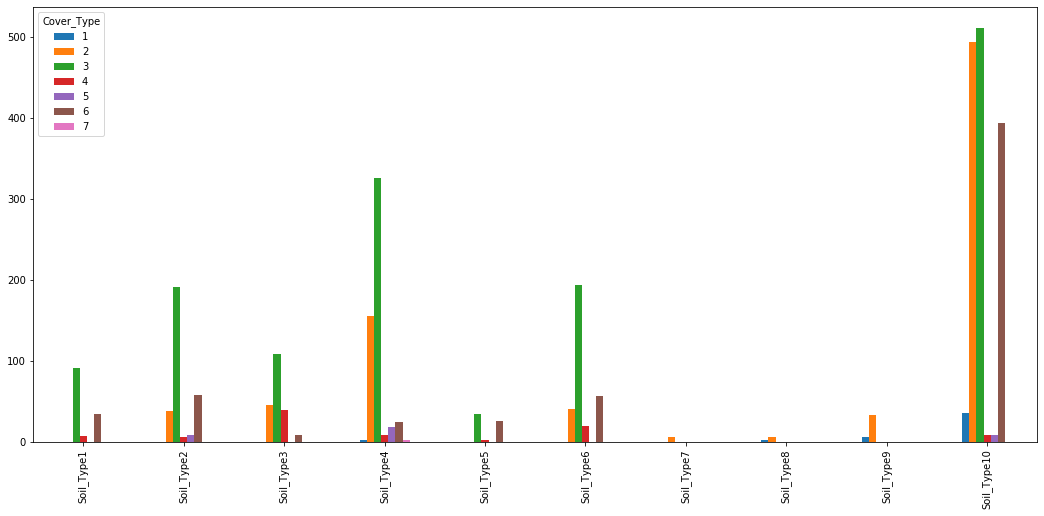

In [41]:
soil_columns = forest_covtype_data.columns[forest_covtype_data.columns.str.contains('Soil')].to_list()
data_soil = forest_covtype_data.groupby(['Cover_Type'])[soil_columns[:10]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))
plt.show()

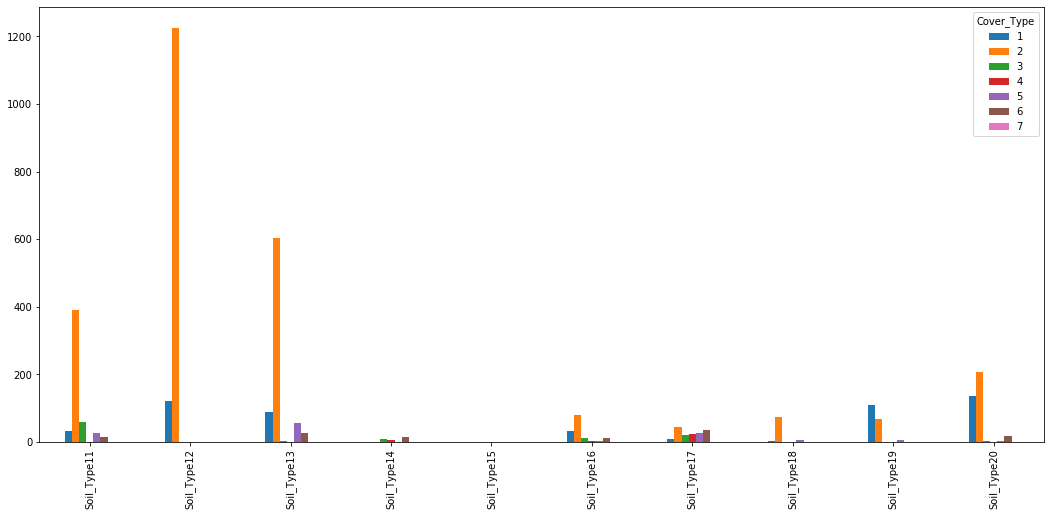

In [42]:
data_soil = forest_covtype_data.groupby(['Cover_Type'])[soil_columns[10:20]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))
plt.show()

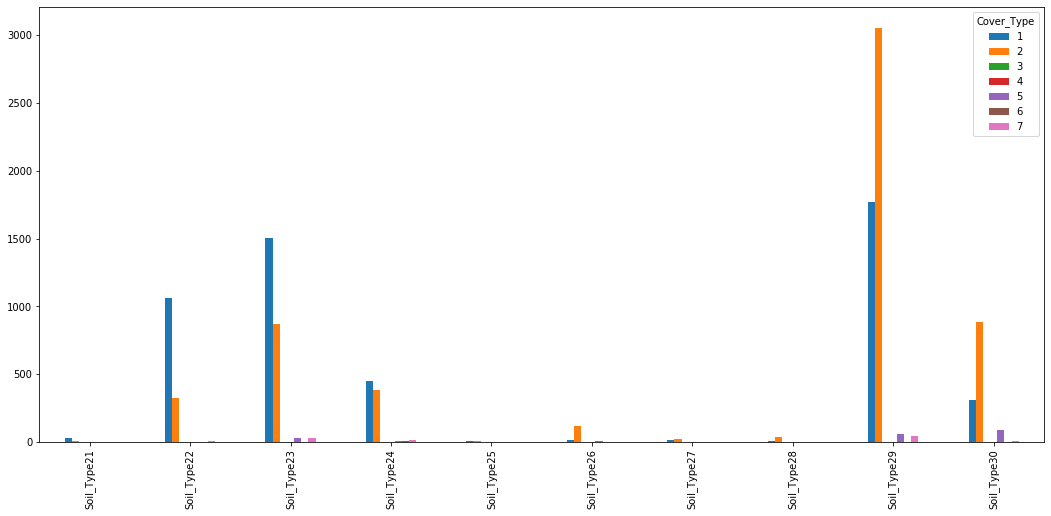

In [43]:
data_soil = forest_covtype_data.groupby(['Cover_Type'])[soil_columns[20:30]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))
plt.show()

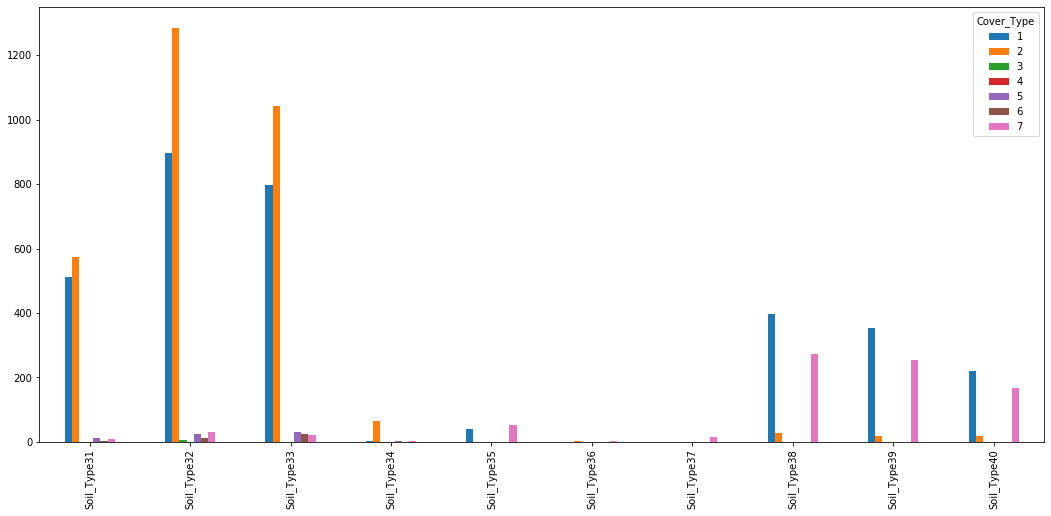

In [44]:
data_soil = forest_covtype_data.groupby(['Cover_Type'])[soil_columns[30:]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))
plt.show()

#### Data Preprocessing

##### Changing the Multi class to Binary class

In [45]:
change = {1:0, 2:1, 3:0, 4:0, 5:0, 6:0, 7:0}
forest_covtype_data_binary = forest_covtype_data.copy()
forest_covtype_data_binary['Cover_Type'] = forest_covtype_data_binary['Cover_Type'].replace(change)

In [46]:
print(forest_covtype_data_binary['Cover_Type'].value_counts())
print(forest_covtype_data_binary.shape)

0    12749
1    12251
Name: Cover_Type, dtype: int64
(25000, 55)


We are going to drop the features which have low standard deviation or co-relation.

In [47]:
forest_covtype_data_binary = forest_covtype_data_binary.loc[:,['Horizontal_Distance_To_Roadways', 'Soil_Type22', 'Soil_Type23', 'Soil_Type29','Horizontal_Distance_To_Fire_Points', 'Slope', 'Wilderness_Area4', 'Soil_Type39', 'Soil_Type38', 'Soil_Type2', 'Soil_Type40', 'Soil_Type4', 'Cover_Type']]

#### Analyzing Plots and Data

The Dataset had no missing values. And no issues from the part of categorical attributes because the datatset we got was already Encoded. And Normalization of the data will be handled during the implementation of each algorithm and that can be done in data preprocessing part also, so no difference in that.

From the data visualizations we were able to conclude the following
- The target data is equally distributed across the cover types
- Elevation plays an important role in forest cover type distribution.krummholz,Spruce and Lodgepole trees grow on higher elevation and douglas,Ponderosa and Cottonwood at lower elevation.
- Cache_La_Poudre and Neota Wilderness Areas have same number of forest covers.But Neota Wild Area has least number of forests compared to other wild areas.We can also see that none of the wild areas have all the types of forest covers.
- We have most of the data for soil type 10 and 29. Many soil types are rare in our data
- We can see that Krummholz and Spruce,Fir trees are located at higher elevation in all the four wild areas compared to other trees.
- Many of the Logdepole,Krummholz are located closer to surface waters

#### Spllitting the data into test and train

In [48]:
# Splitting the data into train(90%) and test(10%)
from sklearn.model_selection import train_test_split
def split(X, T):
    return train_test_split(X, T, test_size = .1)

# Methods

### Neural Networks

Neural networks and deep learning are big topics in Computer Science and in the technology industry, they currently provide the best solutions to many problems in image recognition, speech recognition and natural language processing.

The definition of a neural network, more properly referred to as an 'artificial' neural network (ANN), a computing system made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs.

**Neural Network Architecture**

Input Nodes : No computation is done here within this layer, the input is passed to the next layer

Hidden nodes : In this layer the intemediate processing or computation is done. It is possible to have a neural network without a hidden layer.

Output Nodes: The activation function is used here which maps to the desired output format.

weights and connections : The network consists of connections, each connection transferring the output of a neuron i to the input of a neuron j. In this sense i is the predecessor of j and j is the successor of i, Each connection is assigned a weight Wij.

Activation function : The main purpose of this is to introduce the non linearity to the network. There are several activation fucntions like sigmoid, tanh, ReLU

## 5-fold Cross Validation

### Summary

Cross-validation is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. In a prediction problem, a model is usually given a training data set, and a testing data set of unknown data against which the model is tested. The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like over fitting or selection bias and to give an insight on how the model will generalize to an independent data set.

The activation function does the nonlinear transformation to the input making it capable to learn and sending it to the next layer of neurons. There are several different types of activation function like tanh, ReLu, Leaky ReLu, Sigmoid, step function, etc which can be used in our neural network algorithms to obtain the desired output.

Cross validation divides the training data into several K parts of same size and each part is considered as a testing data. Here we have used 5 fold cross validation which means that for each divided k part, we fir the model with lambda as a parameter to the remaining sub parts and choose the value of lambda which gives the minimum cross validation value.


Normally, KFold crosss validation is implemented using the scikit learn library. In this exercise, I will be implementing it using python.

### Explanation of code

The following approach will be used when implementing this approach

1. Choose K for K-fold cross validation.
2. Set nfold = 0.
3. Initialize the lists res = [], testErrs = [].
4. Split data X and label T into K number of partitions.
5. For each TEST partition
6. For each validation partition among the rest partitions
7. Choose the rest partitions into a training set.
8. For each set P of parameters to test
9. Using P, train the model
10. Use the trained model on the validation data
11. Evaluate the validation result and store the restuls to res
12. From the res result, pick the one with the best result.
13. Retrain the model with the best parameter p in P.
14. Apply the model with the best parameter p* to the test dataset.
15. Evaluate the result err and store the tuple (p*, err) to testErrs.
16. Return testErrs.



In [49]:
def crossValidation(folds, X):
    '''
            This method is performing Cross Validation on Complete Dataset.
            folds: Number of folds we want to try for CV
            X: Complete dataset.
            
            This method will split the complete dataset into test and train data. Make different combinations of hyperparameter
            with hidden units. 
            Finally Calculate Best parameters including hidden units and RMSE value for each fold and at last calculate RMSSE 
            value on test set.
    '''
     
    XTrain, XTest, TTrain, TTest = split(X[:,:-1],X[:,-1:])
    number = int(XTrain.shape[0] / folds)
    
    param_grid = [{'optim': ['scg'], '_lambda': [.001, .01, .1, 1]} ]       # Making different combination of Hyperparameters
    grid = list(ParameterGrid(param_grid))  # Generating the list all possible combinations of hyperparameters
    
    hiddenUnits = [5, 10, XTrain.shape[1], 15, 20]
    
    arr_cv = []
    arr_test = []
    final_param = []
    test_index = []
    bestUnits = []
    for i in range(folds):
        print("     *********************Started the ",i+1," fold*************************\n      ")
        
        lower = number*i
        upper = number*(i+1)
        X_test, T_test = XTrain[lower:upper, :], TTrain[lower:upper, :] # Creating 1st fold as our test data
        XTrain_rem, TTrain_rem = np.delete(XTrain, np.s_[lower:upper], axis= 0), np.delete(TTrain, np.s_[lower:upper], axis= 0) #Deleting the test part and assogning the remaining part 
        
        grid_index = []
        arr_cv = []
        hunits = []
        for j in range(folds-1): # Iterating over next four folds and splitting for validation and training data
            low = number*j
            high = number*(j+1)
            X_validate, T_validate = XTrain_rem[low:high, :], TTrain_rem[low:high, :]
            XTrain_cv, TTrain_cv = np.delete(XTrain_rem, np.s_[low:high], axis= 0), np.delete(TTrain_rem, np.s_[low:high], axis= 0)
            
            for k in range(len(grid)): # Iteratinng over all the combnations of hyperparameters
                for units in range(len(hiddenUnits)):
                    nn_cv = NeuralNet([XTrain.shape[1], hiddenUnits[units], TTrain.shape[1]])
                    nn_cv.train(XTrain_cv, TTrain_cv, **grid[k])
                    ypred_cv = nn_cv.use(X_validate)
                    arr_cv.append(np.sqrt(np.mean((T_validate - ypred_cv)**2)))
                    grid_index.append(k)
                    hunits.append(hiddenUnits[units])
                
        #print("********Validation Errors from ",i+1," fold********* \n")
        #print(arr_cv)
        minimum = arr_cv.index(min(arr_cv)) # Getting the index of minimum errors from array 
        min_index = grid_index[minimum] # Storing that index of best hyperparam. 
        best_hunit = hunits[minimum]
        print(" Best Hyperparameters: ", grid[min_index])
        print(" Best number of hidden units: ", best_hunit)
        
        
        #for index in range(len(grid_index)): # Iterating over the indices of grid indexes to calculate test errors
        nn_cv = NeuralNet([XTrain.shape[1], best_hunit, TTrain.shape[1]])
        nn_cv.train(XTrain_rem, TTrain_rem, **grid[min_index])
        ypred_test = nn_cv.use(X_test)
        arr_test.append(np.sqrt(np.mean((T_test - ypred_test)**2))) # Calculating test error from best parameters from validation sets
        test_index.append(min_index) # Storing the corresponding index from grid_index with rmse
        bestUnits.append(best_hunit)
        print(" RMSE value for this test set: ",np.sqrt(np.mean((T_test - ypred_test)**2)))
            
    #print("**************Test Errors from all the fold***************\n")
    #print(arr_test)
    #minimum_test = arr_test.index(min(arr_test))
    index= arr_test.index(min(arr_test)) # Storing the index of best hyperparameters after running onto all folds test cases.
    final_param = grid[test_index[index]]
    print("            \nFinal Hyperparameters are: ",final_param)
    final_units = bestUnits[index]
    print("              Final hidden units are: ",final_units)
    
    nn_cv = NeuralNet([XTrain.shape[1], final_units, TTrain.shape[1]])
    nn_cv.train(XTrain, TTrain, **final_param)
    ypred = nn_cv.use(XTest)
    
    print("              Final RMSE after 5-fold cross validation: ",np.sqrt(np.mean((TTest - ypred)**2)))
    return TTest, ypred


## Nonlinear Regression 

### Summary

Nonlinear regression is a form of regression analysis in which observational data are modeled by a function which is a nonlinear combination of the model parameters and depends on one or more independent variables. In the past, advanced modelers would work with nonlinear functions, including exponential functions, logarithmic functions, trigonometric functions, power functions, Gaussian function, and Lorenz curves. Some of these functions, such as the exponential or logarithmic functions, would then be transformed so that they would be linear. When so transformed, standard linear regression would be performed, but the classical approach has significant problems, especially if the modeler is working with larger datasets and/or if the data includes missing values, nonlinear relationships, local patterns and interactions.

In nonlinear regression, a statistical model of the form, $y = f(z, \beta)$

relates a vector of independent variables, x, and its associated observed dependent variables, y. The function f is nonlinear in the components of the vector of parameters β, but otherwise arbitrary. For example, the Michaelis–Menten model for enzyme kinetics has two parameters and one independent variable, related by f by:

$
f(z, \beta) = \frac{\beta1.z}{\beta2\,+\, z}\\
$

This function is nonlinear because it cannot be expressed as a linear combination of the two β's.

The leanring rate is meant to be customisable so that once the trianing starts we can check if we are overfitting the data or not. The right leanring rate and the number of epochs can help determine if A perfect learning rate is neither too high nor too low. It has the right amount of activation so as to give an output which fits the data perfectly. Each iteration is a batch optimization, where each time a full forward and backword prop takes place on the entire data, this having a high value can cause overfitting, and a low value can cause underfitting. A perfect balance between the above hyperparameters is essential.Non Linear Regression is all about controlling hyperparameters, changing the hidden layers hyperparameters, and this process can achieve the right amount of non linearity.


### Explanation of codes

From the classes imported above, we can infer that the Standardizer class normalizes all the values and the NeuralNet class builds the neural network that learns the data through feed forward and back propagation.

The number of inputs, hidden units, and outputs are mentioned by nunits and set_hunit function is used to either update or initiate the weights which is taken as a parameter. The Pack function packs the multiple weights of each layer into one vector and the unpack function does the opposite.
Forward pass in neural network propagates as follows:

$$
\begin{align}
Z &amp;= h(Xl \cdot V) \\
\\
Y &amp; = Zl \cdot W 
\end{align}
$$
Activation function is used to make the network nonlinear. In the backward pass the function takes the the z values, Target values and the error as input. Based on the delta value, the weights and the bias are updated accoringly. This method returns the weight vector packed together of that particular layer.

The train function takes the feautures and the target as the input. The gradientf unpacks the weights,proceeds with the forward pass by calling forward function. Error is calculated using results of forward pass. Now back propagation is proceeded by calling it's function with parameters as error, Z, T(Target), _lambda.

Following functions that are excecuted during backward pass:

$$
\begin{align}
V &amp;\leftarrow V + \alpha_h \frac{1}{N} \frac{1}{K} Xl^\top \Big( (T - Y) W^\top \odot (1 - Z^2) \Big) \\
W &amp;\leftarrow W + \alpha_o \frac{1}{N} \frac{1}{K} Zl^\top \Big( T - Y \Big) 
\end{align}
$$
Use function is applied to the test data after training the model. Testing data is passed as parameter and it stadardizes the data. Then forward is applied on the data which returns the predictions.

#### Non-Linear Regression on Complete Regression Dataset

In [50]:
# X = pd.concat([bike_sharing_data.iloc[:,:40], df_regression.iloc[:,40:58]], axis= 1)
# T = df_regression.iloc[:,-1:]
X =  bike_sharing_data.drop('count',axis=1)
T =  pd.DataFrame(bike_sharing_data['count'])
print("Shape of X{} and T{}".format(X.shape, T.shape))
df_regression_new = pd.concat([X, T], axis= 1)
print("Shape of new dataframe", df_regression_new.shape)

Shape of X(17135, 53) and T(17135, 1)
Shape of new dataframe (17135, 54)


In the above cell we are just removing the unimportamt columns according to the correlation table.

In [51]:
X_train, X_test, T_train, T_test = split(X.values, T.values)
print("Shape of X_train {}, X_test {}, T_train {}, T_test{}".format(X_train.shape, X_test.shape, T_train.shape, T_test.shape))

Shape of X_train (15421, 53), X_test (1714, 53), T_train (15421, 1), T_test(1714, 1)


In [52]:
nn = NeuralNet([X_train.shape[1], 3, T_train.shape[1]])
nn.train(X_train, T_train)
t_pred = nn.use(X_test)
print(np.sqrt(np.mean((T_test - t_pred)**2)))

73.77268064241602


#### Non-Linear regression results from 5-fold cross validation

In [53]:
testSet, tPred = crossValidation(5, df_regression_new.values)

     *********************Started the  1  fold*************************
      
 Best Hyperparameters:  {'_lambda': 1, 'optim': 'scg'}
 Best number of hidden units:  5
 RMSE value for this test set:  70.30191871450567
     *********************Started the  2  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.01, 'optim': 'scg'}
 Best number of hidden units:  10
 RMSE value for this test set:  71.84169802225155
     *********************Started the  3  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  5
 RMSE value for this test set:  71.12735635792825
     *********************Started the  4  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.01, 'optim': 'scg'}
 Best number of hidden units:  10
 RMSE value for this test set:  70.08537047981977
     *********************Started the  5  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.1, 

## Nonlinear Logistic Regression

### Summary

linear logistic regression uses the softmax layer for classification along with a linear model as follows:

$$
g_k(x) = P(T=k \mid x) = \frac{e^{\kappa_k}}{\sum_{c=1}^K e^{\kappa_c}}
$$
By using the above function, we can generate probablistic outputs for all classes. To handle multi-label classes, we use the indicator target labels for training to update the weights for the linear model. Following the derivation, update rule is achieved as follows:

$$
w_j \leftarrow w_j + \alpha \sum_{n=1}^{N} \Big( t_{n,j} - g_j(x_n)\Big) x_n.
$$
whose matrix form is as follows:$$
w \leftarrow w + \alpha X^\top \Big(  T - g(X)\Big).
$$

and the error function as,

$$
E(w) = - \ln P(T \mid w) =  - \sum_{n=1}^{N} \sum_{k=1}^{K} t_{n,k} \ln y_{n,k}.
$$
In nonlinear logistic regression extra layers are added called as hidden layers. With the inclusion of hidden layer the softmax function is used in the last layer. Till then the input layer passes its output to hidden layer, then the hidden layer to another hidden layer or softmax function and the softmax function then gives the output.

$$
wv_j \leftarrow wv_j + \alpha \sum_{n=1}^{N} \Big( t_{n,j} - g_j(xv_n)\Big) xv_n.
 $$

### Explanation of code


In NeuralNetLogReg class, init function is a constructor of the class which calls the NeuralNet class' constructor for assigning values to the number of layers for the model where nLayers is the number of hidden unit layers, rho is the learning rate attribute of the class, W is the weights written in one dimension. stdX and stdT is the standardization class for the data and target respectively.

The train function takes the features and target as input. The gradient unpacks the weights,proceeds with the forward pass by calling forward function. Now error is calculated using results of forward pass. Now back propagation is proceeded by calling backward function with parameters as error, Z, T(Target), _lambda

Forward pass in neural network propagates same as in the class discussed above the only difference is that and an additional t=self.softmax(t) is added to the last layer. The last layer will be the softmax function which then gives output to the output layer. Activation function is used to make the network nonlinear.

Backward pass in neural network takes the the z values, target values and the error as input. Based on the delta value, the weights and the bias are updated accoringly. This method returns the weight vector packed together of that particualr layer. Below are the functions that are excecuted during backward pass.

$$
 W \leftarrow W + \alpha_o Zl^\top \Big(  T - g(X)\Big).
 $$

$$
 V \leftarrow V + \alpha_h Xl^\top \Big( (T - g(X)) W^\top \odot (1 - Z^2) \Big).
$$

In [54]:
from nn import NeuralNet

class NeuralNetLogReg(NeuralNet):
    """ Nonlinear Logistic Regression
    """

    # if you think, you need additional items to initialize here,
    # add your code for it here
    def __init__(self, nunits):
        super().__init__(nunits)
    
    def softmax(self, z):
        f = np.exp(z)
        return f / np.sum(f, axis=1, keepdims=True)

    # Looking at the final summary or comparison table in lecture note,
    # add your codes for forward pass for logistic regression
    def forward(self, X):
        t, Z = super().forward(X)
        return self.softmax(t), Z
    

    # This is the error function that we want to minimize
    # what was it? take a look at the lecture note to fill in
    def _objectf(self, T, Y, wpenalty):
        return -(np.sum(np.sum(T * np.log(Y), axis= 1), axis= 0)) + wpenalty

    # you must reuse the NeuralNet train since you already modified
    # the objective or error function (maybe both), 
    # you do not have many to change here.
    # MAKE SURE convert a vector label T to indicator matrix and 
    # feed that for training
    def train(self, X, T, **params):
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        Ttrain = onehot_encoder.fit_transform(T)
        return super().train(X, Ttrain, **params)

    # going through forward pass, you will have the probabilities for each label
    # now, you can use argmax to find class labels
    # return both label and probabilities        
    def use(self, X):
        if self.stdX:
            Xs = self.stdX.standardize(X)
        else:
            Xs = X
        G, Z = self.forward(Xs)
        classes = np.argmax(G, axis = 1)
        #prob = np.amax(G, axis = 1 )
        return classes, G

### Examination on Toy Data

Text(0.5, 1.0, 'test data set')

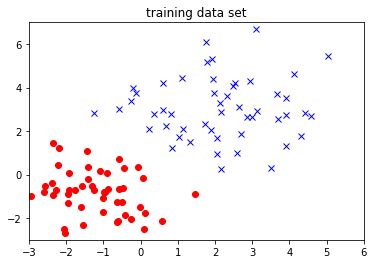

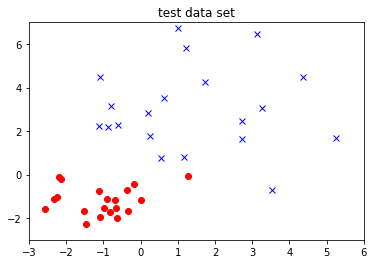

In [55]:
# Data for testing
N1 = 50
N2 = 50
N = N1 + N2
D = 2
K = 2

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

#
#  Train Data
#
C1 = np.random.multivariate_normal(mu1, cov1, N1)
C2 = np.random.multivariate_normal(mu2, cov2, N2)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])
plt.title("training data set")

Xtrain = np.vstack((C1, C2))
Ttrain = np.zeros((N, 1))
Ttrain[50:, :] = 1  # labels are zero or one

means, stds = np.mean(Xtrain, 0), np.std(Xtrain, 0)
# normalize inputs
Xtrains = (Xtrain - means) / stds

#
#  Test Data
#
Ct1 = np.random.multivariate_normal(mu1, cov1, 20)
Ct2 = np.random.multivariate_normal(mu2, cov2, 20)

Xtest = np.vstack((Ct1, Ct2))
Ttest = np.zeros((40, 1))
Ttest[20:, :] = 1

# normalize inputs
Xtests = (Xtrain - means) / stds


plt.figure()
plt.plot(Ct1[:, 0], Ct1[:, 1], 'or')
plt.plot(Ct2[:, 0], Ct2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])
plt.title("test data set")

In [56]:
logistic = NeuralNetLogReg([2, 4, 2])

logistic.train(Xtrain, Ttrain)
classes, Y = logistic.use(Xtest)
print(Xtest.shape)

(40, 2)


In [57]:
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Accuracy:  50.0 %


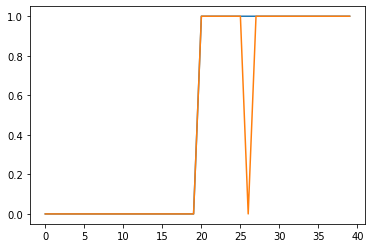

In [58]:
plt.plot(Ttest)
plt.plot(classes)

print("Accuracy: ", 100 - np.mean(np.abs(Ttest - classes)) * 100, "%")

### Non-Linear Logistic Regression on Complete Classification dataset

In [59]:
X_train_log, X_test_log, T_train_log, T_test_log = split(forest_covtype_data_binary.iloc[:,:-1].values, forest_covtype_data_binary.iloc[:,-1:].values)
print("Shape of X_train_log {}, X_test_log {}, T_train_log {}, T_test_log{}".format(X_train_log.shape, X_test_log.shape, T_train_log.shape, T_test_log.shape))

Shape of X_train_log (22500, 12), X_test_log (2500, 12), T_train_log (22500, 1), T_test_log(2500, 1)


In [60]:
number_classes = len(np.unique(T_train_log))
print(number_classes)

2


In [61]:
logistic_data = NeuralNetLogReg([X_train_log.shape[1], 2, number_classes])

logistic_data.train(X_train_log, T_train_log)
classes_data, prob = logistic_data.use(X_test_log)

In [62]:
print(classes_data)
print(prob)
print("Accuracy: ", 100 - np.mean(np.abs(T_test_log - classes_data)) * 100, "%")

[0 0 0 ... 0 0 0]
[[1.00000000e+00 9.06914524e-39]
 [1.00000000e+00 9.06914524e-39]
 [1.00000000e+00 9.06914524e-39]
 ...
 [1.00000000e+00 9.06914524e-39]
 [1.00000000e+00 9.06914524e-39]
 [1.00000000e+00 9.06914524e-39]]
Accuracy:  51.186048 %


In [63]:
confusion_matrix(T_test_log, classes_data)

array([[1177,  114],
       [ 977,  232]])

### Cross Validation of logistic regression

In [64]:
def crossValidation_logistic(folds, X):
    XTrain, XTest, Train, TTest = split(X[:,:-1],X[:,-1:])
    number = int(XTrain.shape[0] / folds)
    number_classes = len(np.unique(Train))
    
    param_grid = [{'optim': ['scg'], '_lambda': [.001, .01, .1, 1]} ]       # Making different combination of Hyperparameters
    grid = list(ParameterGrid(param_grid))  # Generating the list all possible combinations of hyperparameters
    
    hiddenUnits = [5, 10, XTrain.shape[1], 15, 20]
    
    arr_cv = []
    arr_test = []
    final_param = []
    test_index = []
    bestUnits = []
    for i in range(folds):
        print("     *********************Started the ",i+1," fold*************************\n      ")
        
        lower = number*i
        upper = number*(i+1)
        X_test, T_test = XTrain[lower:upper, :], Train[lower:upper, :] # Creating 1st fold as our test data
        XTrain_rem, Train_rem = np.delete(XTrain, np.s_[lower:upper], axis= 0), np.delete(Train, np.s_[lower:upper], axis= 0) #Deleting the test part and assogning the remaining part 
        
        grid_index = []
        arr_cv = []
        hunits = []
        for j in range(folds-1): # Iterating over next four folds and splitting for validation and training data
            low = number*j
            high = number*(j+1)
            X_validate, T_validate = XTrain_rem[low:high, :], Train_rem[low:high, :]
            XTrain_cv, Train_cv = np.delete(XTrain_rem, np.s_[low:high], axis= 0), np.delete(Train_rem, np.s_[low:high], axis= 0)
            
            for k in range(len(grid)): # Iterating over all the combnations of hyperparameters
                for units in range(len(hiddenUnits)):
                    nn_cv = NeuralNetLogReg([XTrain.shape[1], hiddenUnits[units], number_classes])
                    nn_cv.train(XTrain_cv, Train_cv, **grid[k])
                    ypred_cv, G = nn_cv.use(X_validate)
                    arr_cv.append(np.mean(np.abs(T_validate - ypred_cv) * 100))
                    grid_index.append(k)
                    hunits.append(hiddenUnits[units])
                
        minimum = arr_cv.index(max(arr_cv)) # Getting the index of maximum accuracy from array 
        min_index = grid_index[minimum] # Storing that index of best hyperparam. 
        best_hunit = hunits[minimum]
        print(" Best set of Hyperparameters: ", grid[min_index])
        print(" Best number of hidden units: ", best_hunit)
        
        
        #for index in range(len(grid_index)): # Iterating over the indices of grid indexes to calculate test errors
        nn_cv = NeuralNetLogReg([XTrain.shape[1], best_hunit, number_classes])
        nn_cv.train(XTrain_rem, Train_rem, **grid[min_index])
        ypred_test, G = nn_cv.use(X_test)
        arr_test.append(100 - np.mean(np.abs(T_test - ypred_test) * 100)) # Calculating test error from best parameters from validation sets
        test_index.append(min_index) # Storing the corresponding index from grid_index with rmse
        bestUnits.append(best_hunit)
        print(" Test Accuracy for Test set: ",100 - np.mean(np.abs(T_test - ypred_test) * 100))
            
    index= arr_test.index(max(arr_test)) # Storing the index of best hyperparameters after running onto all folds test cases.
    final_param = grid[test_index[index]]
    print("\n    Final Hyperparameters are:",final_param)
    final_units = bestUnits[index]
    print("      Final hidden units are:",final_units)
    
    nn_cv = NeuralNetLogReg([XTrain.shape[1], final_units, number_classes])
    nn_cv.train(XTrain, Train, **final_param)
    ypred, G = nn_cv.use(XTest)
    
    print("      Final Accuracy after 5-fold cross validation: ",100 - np.mean(np.abs(TTest - ypred) * 100))
    return TTest, ypred, G


In [65]:
test, Tpredicted, G = crossValidation_logistic(5, forest_covtype_data_binary.values)

     *********************Started the  1  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  5
 Test Accuracy for Test set:  49.8140049382716
     *********************Started the  2  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 1, 'optim': 'scg'}
 Best number of hidden units:  5
 Test Accuracy for Test set:  50.2593975308642
     *********************Started the  3  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.01, 'optim': 'scg'}
 Best number of hidden units:  20
 Test Accuracy for Test set:  49.907022222222224
     *********************Started the  4  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.1, 'optim': 'scg'}
 Best number of hidden units:  20
 Test Accuracy for Test set:  49.413037037037036
     *********************Started the  5  fold*************************
      
 Best set of Hyperpara

# Results

### cross Validation Results Comparision for Non-Linear Regression

#### Non-Linear Regression results


<table style="width:100%">
    <h4 align='center'>Results for Each Validation</h4>
  <tr>
    <th>Fold</th>
    <th>Best Hyperparameters</th>
    <th>Best Number of Hidden Units</th> 
    <th>RMSE Value</th>
  </tr>
  <tr>
    <td>Fold 1</td>
    <td>{'_lambda': 0.01, 'optim': 'scg'}</td> 
    <td>5</td>
    <td>70.30191871450567</td>
  </tr>
   <tr>
    <td>Fold 2</td>
    <td>{'_lambda': 0.001, 'optim': 'scg'}</td> 
    <td>10</td>
    <td>71.84169802225155</td> 
  </tr>
   <tr>
    <td>Fold 3</td>
    <td>{'_lambda': 0.001, 'optim': 'scg'}</td> 
    <td>5</td>
    <td>71.12735635792825</td>
  </tr>
    <tr>
    <td>Fold 4</td>
    <td>{'_lambda': 0.01, 'optim': 'scg'}</td> 
    <td>10</td>
    <td>70.08537047981977</td> 
  </tr>
   <tr>
    <td>Fold 5</td>
     <td>{'_lambda': 0.1, 'optim': 'scg'}</td> 
    <td>5</td>
    <td>71.40123120378054</td>
  </tr>
</table>

<table>
    <h4 align ='center'>Final Results After 5 fold Validation</h4>
    <tr>
        <th>Final Hyperparameters</th>
        <th>Final umber of Hidden Units</th> 
        <th>RMSE Value for original test set</th>
    </tr>
    <tr>
        <th>{'_lambda': 0.01, 'optim': 'scg'}</th>
        <th>10</th>
        <th>70.84037936089145</th>
    </tr>
</table>

#### Non-Linear Logistic Regression

<table style="width:100%">
    <h4 align='center'>Results for Each Validation</h4>
  <tr>
    <th>Fold</th>
    <th>Best Hyperparameters</th>
    <th>Best Number of Hidden Units</th> 
    <th>Accuracy</th>
  </tr>
  <tr>
    <td>Fold 1</td>
    <td>{'_lambda': 0.001, 'optim': 'scg'}</td> 
    <td>5</td>
    <td>49.8140049382716</td>
  </tr>
   <tr>
    <td>Fold 2</td>
    <td>{'_lambda': 1, 'optim': 'scg'}</td> 
    <td>5</td>
    <td>50.2593975308642</td> 
  </tr>
   <tr>
    <td>Fold 3</td>
    <td>{'_lambda': 0.01, 'optim': 'scg'}</td> 
    <td>20</td>
    <td>49.907022222222224</td>
  </tr>
    <tr>
    <td>Fold 4</td>
    <td>{'_lambda': 0.1, 'optim': 'scg'}</td> 
    <td>20</td>
    <td>49.907022222222224</td> 
  </tr>
   <tr>
    <td>Fold 5</td>
     <td>{'_lambda': 1, 'optim': 'scg'}</td> 
    <td>12</td>
    <td>49.156543209876546</td>
  </tr>
</table>

<table>
    <h4 align ='center'>Final Results After 5 fold Validation</h4>
    <tr>
        <th>Final Hyperparameters</th>
        <th>Final umber of Hidden Units</th> 
        <th>Accuracy for original test set</th>
    </tr>
    <tr>
        <th> {'_lambda': 1, 'optim': 'scg'}</th>
        <th>5</th>
        <th>48.9216</th>
    </tr>
</table>


### Discussion about parameter choices

The most critical aspect of achieving the best outcomes from our model is the specification of the parameters. Begin with our class object initialization, a list containing 3 objects is passed: 

1. Number of inputs.
2. Number of hidden units.
3. Number of outputs/classes.

Out of these three, only a number of units can be tuned. So we specified a list of different numbers of hidden units in our crossValidation function, to which we tuned our model.

Apart from this when we call our train system, we can play around with a variety of other parameters, if we like. We also call these parameters our hypeparameters. By design, they have been initialized with some meaning in the train system, but we can tune them to improve our precision. 

We have specified a dictionary list (param grid) in the Cross validation method consisting of the name of the parameter(key) and the number of values we want to try with other combinations for that same parameter. Finally, we have generated a list of all the parameters of combinations we want to train our model.

We hold our number of parameters just two (optimal and lambda) because of computational time complexity, but we can also pursue other combinations. For first validation sets, our model will run with all the collection of parameters and choose the best from that and run the parameter combination in each fold for the test set. For each number of folds, this procedure is repeated (in our case it is 5). Finally, all test sets collected after each fold are ideally selected from the test parameter set. We are running our final test set (which was never added to the model) for that set of parameters.

## Plots

#### This plot refers to the Non-linear regression run on complete dataset without cross validation.

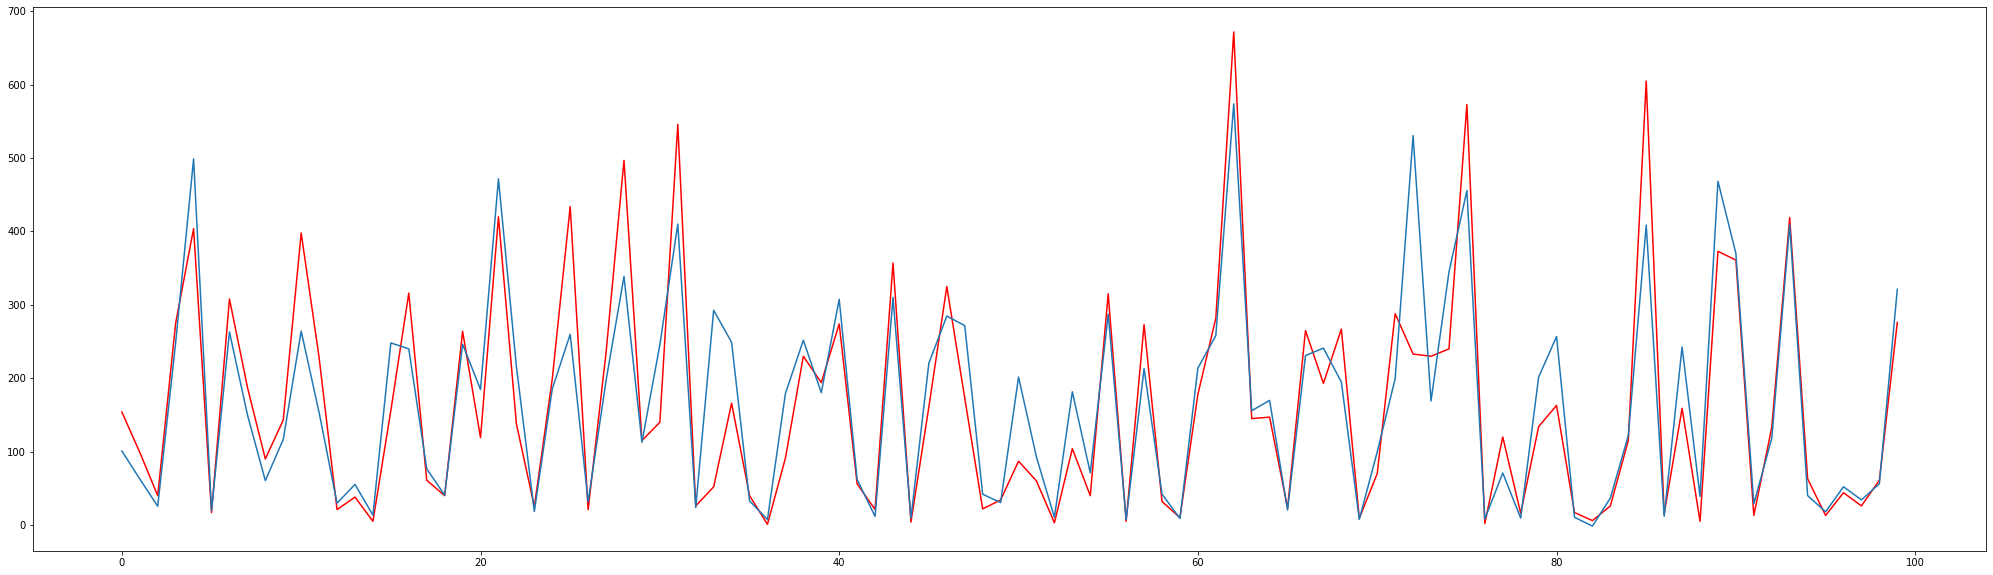

In [66]:

plt.figure(figsize=(35,10))
plt.plot(T_test[:100],'r')
plt.plot(t_pred[:100])

#### This plot refers to the Non-linear regression run on completely on cross validation. 

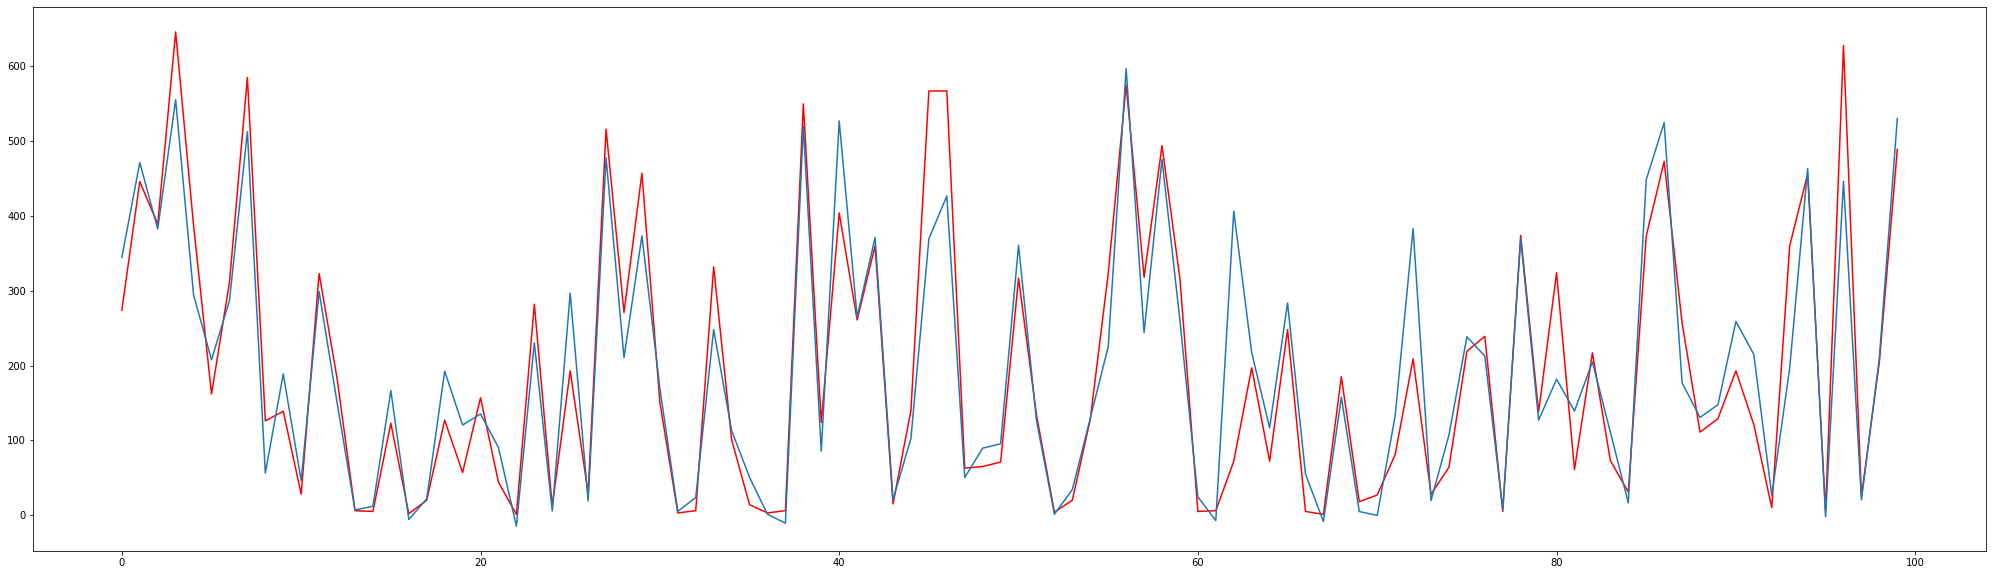

In [67]:
plt.figure(figsize=(35,10))
plt.plot(testSet[:100],'r')
plt.plot(tPred[:100])

#### This plot refers to the Non-linear logistic regression run on complete dataset without cross validation.

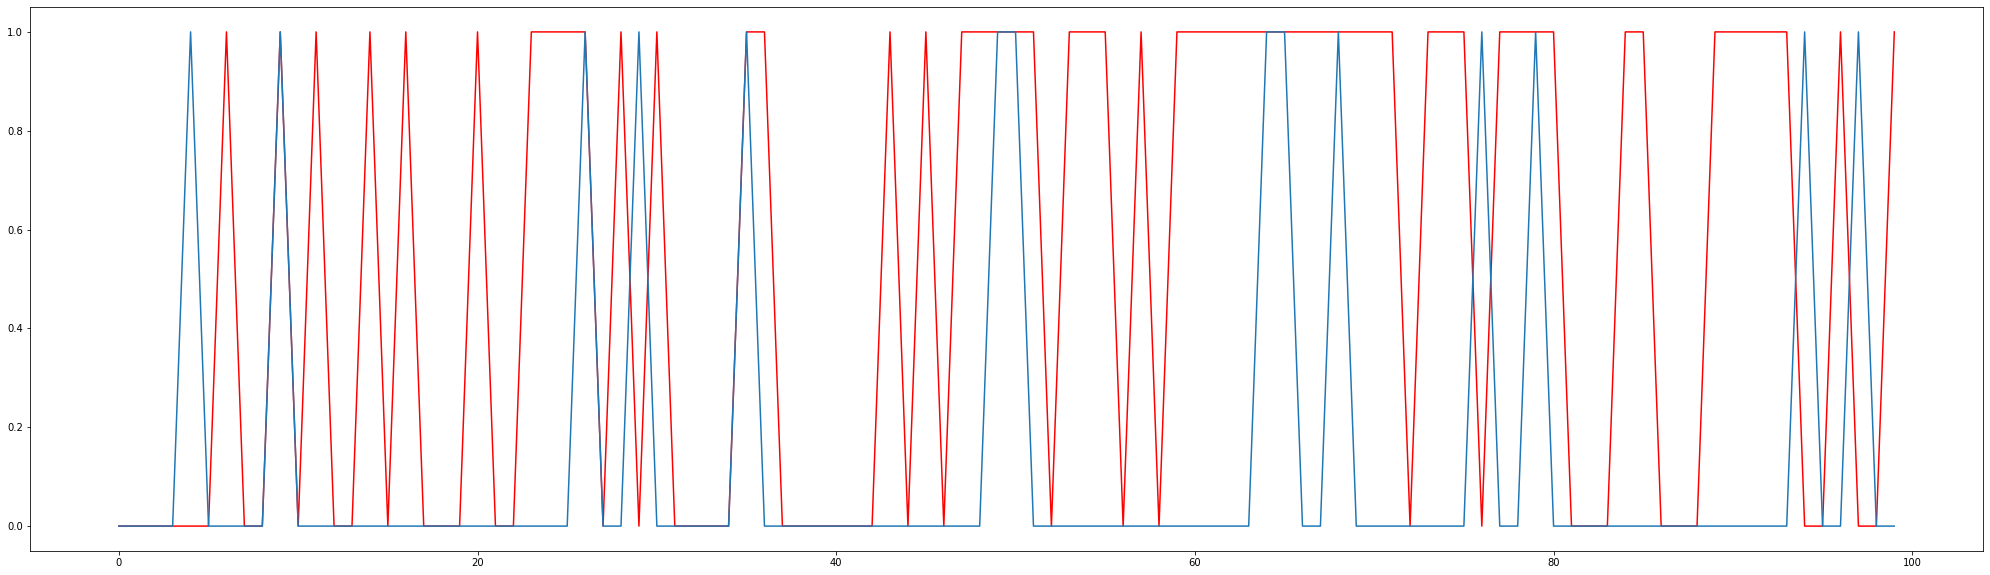

In [68]:
plt.figure(figsize=(35,10))
plt.plot(T_test_log[:100],'r')
plt.plot(classes_data[:100])

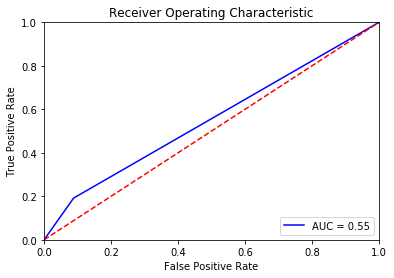

In [69]:
from sklearn.metrics import roc_curve
fpr_logistic, tpr_logistic, threshold_logistic = roc_curve(T_test_log, classes_data)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr_logistic, tpr_logistic, 'b', label = 'AUC = %0.2f' % roc_auc_logistic)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### This plot refers to the Non-linear regression run on completely on cross validation.

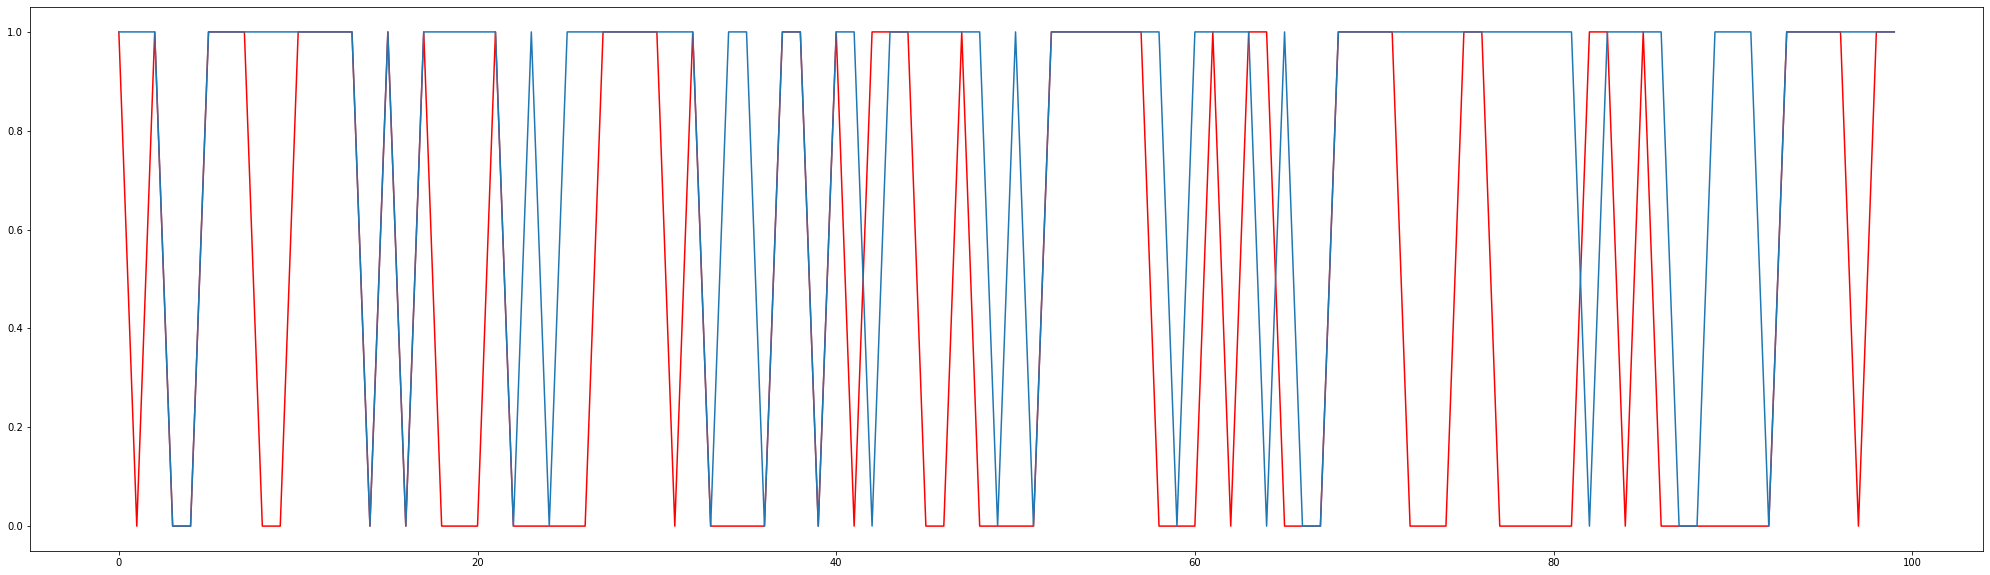

In [70]:
plt.figure(figsize=(35,10))
plt.plot(test[:100],'r')
plt.plot(Tpredicted[:100])

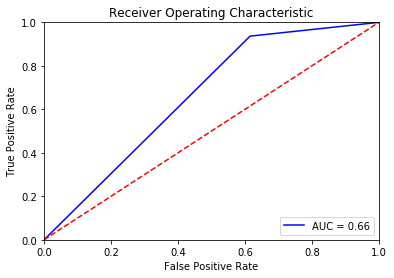

In [71]:
from sklearn.metrics import roc_curve
fpr_logistic, tpr_logistic, threshold_logistic = roc_curve(test, Tpredicted)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr_logistic, tpr_logistic, 'b', label = 'AUC = %0.2f' % roc_auc_logistic)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Discussion about prediction results

Through running the algorithm directly and both by cross validation and hyperparameter tuning, we have seen the effects for both algorithms. As far as Non-Linear regression is concerned, outcomes are greatly enhanced by cross validation and parameter tuning relative to direct implementation on the whole dataset. When we ran the algorithm on a complete dataset, we plotted the graph between the real test results and the expected value. But to provide greater reference visualization, the graph plotted is only for the 100 rows.

We attempt to tune our model to various hyperparameter sets such as 'optim', 'lambda', 'number of hidden units' during 5-fold cross validation. Because of the statistical complexity, we sought less combinations of hyperparameters. But if we try to get more hyperparameter values or more parameters, we could get better results.

The case for non-linear logistic regression is almost identical. The findings from the above graphs, which are plotted between expected groups and our target variable, may be visualized. Similar to the non-linear regression map, we took 100 rows to help visualize the results, and we can see from the ROC curve that we obtained 66 percent precision, which is very good. In our case, we obtained approximately 50 percent precision for all the folds as well as in the final result, which is marginally better than without cross-validation results. If we increase our hyperparameter number and test out more values in them, it could be due to our dataset or may increase. Due to computational time complexity, we kept the number of hyperparameters down. 



# Trying with Different Activation Functions

There are three main Activation function that we will be discussing:

1. Tanh function: This function we have already used in our implementation.
2. Sigmoid function
3. ReLu function


## 2. Implementation of both algorithms through Sigmoid function

In [72]:
class NeuralNetSigmoid(NeuralNet):
    '''
        We are defining a new class for calculating results for non-linear regression using Sigmoid function.
        We are inheriting NeurelNet and make changes only in the forward function where it is using activation function.
    '''
    
    def _init_(self,nunits):
        NeuralNet._init_(self,nunits)
    
   
    def sigmoid(self,X):
        return 1 / ( 1 + np.exp(-X))

    def forward(self,X):
        t = X 
        Z = []

        for i in range(self._nLayers):
            Z.append(t) 
            if i == self._nLayers - 1:
                t = np.dot(self.add_ones(t), self._W[i])
            else:
                t = self.sigmoid(np.dot(self.add_ones(t), self._W[i]))
        return (t, Z)

In [73]:
nn_sig = NeuralNetSigmoid([X_train.shape[1], 3, T_train.shape[1]]) 
nn_sig.train(X_train, T_train)
t_pred_sig = nn_sig.use(X_test)
print(np.sqrt(np.mean((T_test - t_pred_sig)**2)))


106.24312996841242


In [74]:
# Cross validation for sigmoid non-linear regression
def crossValidation_Sigmoid(folds, X):
    XTrain, XTest, TTrain, TTest = split(X[:,:-1],X[:,-1:])
    number = int(XTrain.shape[0] / folds)
    
    param_grid = [{'optim': ['scg'], '_lambda': [.001, .01, .1, 1]} ]       # Making different combination of Hyperparameters
    grid = list(ParameterGrid(param_grid))  # Generating the list all possible combinations of hyperparameters
    
    hiddenUnits = [5, 10, XTrain.shape[1], 15, 20]
    
    arr_cv = []
    arr_test = []
    final_param = []
    test_index = []
    bestUnits = []
    for i in range(folds):
        print("     *********************Started the ",i+1," fold*************************\n      ")
        
        lower = number*i
        upper = number*(i+1)
        X_test, T_test = XTrain[lower:upper, :], TTrain[lower:upper, :] # Creating 1st fold as our test data
        XTrain_rem, TTrain_rem = np.delete(XTrain, np.s_[lower:upper], axis= 0), np.delete(TTrain, np.s_[lower:upper], axis= 0) #Deleting the test part and assogning the remaining part 
        
        grid_index = []
        arr_cv = []
        hunits = []
        for j in range(folds-1): # Iterating over next four folds and splitting for validation and training data
            low = number*j
            high = number*(j+1)
            X_validate, T_validate = XTrain_rem[low:high, :], TTrain_rem[low:high, :]
            XTrain_cv, TTrain_cv = np.delete(XTrain_rem, np.s_[low:high], axis= 0), np.delete(TTrain_rem, np.s_[low:high], axis= 0)
            
            for k in range(len(grid)): # Iteratinng over all the combnations of hyperparameters
                for units in range(len(hiddenUnits)):
                    nn_cv = NeuralNetSigmoid([XTrain.shape[1], hiddenUnits[units], TTrain.shape[1]])
                    nn_cv.train(XTrain_cv, TTrain_cv, **grid[k])
                    ypred_cv = nn_cv.use(X_validate)
                    arr_cv.append(np.sqrt(np.mean((T_validate - ypred_cv)**2)))
                    grid_index.append(k)
                    hunits.append(hiddenUnits[units])
                
        #print("********Validation Errors from ",i+1," fold********* \n")
        #print(arr_cv)
        minimum = arr_cv.index(min(arr_cv)) # Getting the index of minimum errors from array 
        min_index = grid_index[minimum] # Storing that index of best hyperparam. 
        best_hunit = hunits[minimum]
        print(" Best Hyperparameters: ", grid[min_index])
        print(" Best number of hidden units: ", best_hunit)
        
        
        #for index in range(len(grid_index)): # Iterating over the indices of grid indexes to calculate test errors
        nn_cv = NeuralNetSigmoid([XTrain.shape[1], best_hunit, TTrain.shape[1]])
        nn_cv.train(XTrain_rem, TTrain_rem, **grid[min_index])
        ypred_test = nn_cv.use(X_test)
        arr_test.append(np.sqrt(np.mean((T_test - ypred_test)**2))) # Calculating test error from best parameters from validation sets
        test_index.append(min_index) # Storing the corresponding index from grid_index with rmse
        bestUnits.append(best_hunit)
        print(" RMSE value for this test set: ",np.sqrt(np.mean((T_test - ypred_test)**2)))
            
    #print("**************Test Errors from all the fold***************\n")
    #print(arr_test)
    #minimum_test = arr_test.index(min(arr_test))
    index= arr_test.index(min(arr_test)) # Storing the index of best hyperparameters after running onto all folds test cases.
    final_param = grid[test_index[index]]
    print("            \nFinal Hyperparameters are: ",final_param)
    final_units = bestUnits[index]
    print("              Final hidden units are: ",final_units)
    
    nn_cv = NeuralNetSigmoid([XTrain.shape[1], final_units, TTrain.shape[1]])
    nn_cv.train(XTrain, TTrain, **final_param)
    ypred = nn_cv.use(XTest)
    
    print("              Final RMSE after 5-fold cross validation: ",np.sqrt(np.mean((TTest - ypred)**2)))
    return TTest, ypred

In [75]:
testSet_sig, tPred_sig = crossValidation_Sigmoid(5, df_regression_new.values)

     *********************Started the  1  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.01, 'optim': 'scg'}
 Best number of hidden units:  15
 RMSE value for this test set:  105.2375028481702
     *********************Started the  2  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  5
 RMSE value for this test set:  125.40017300970494
     *********************Started the  3  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  53
 RMSE value for this test set:  102.87693844646562
     *********************Started the  4  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  5
 RMSE value for this test set:  111.86979837706228
     *********************Started the  5  fold*************************
      
 Best Hyperparameters:  {'_lambda

### Non_linear logistic regression using sigmoid function

In [76]:
from nn import NeuralNet

class NeuralNetLogRegSigmoid(NeuralNetLogReg):
    """ Nonlinear Logistic Regression
    """

    def __init__(self, nunits):
        super().__init__(nunits)
 
    def sigmoid(self,X):
        return 1 / ( 1 + np.exp(-X))

    def forward(self,X):
        t = X 
        Z = []

        for i in range(self._nLayers):
            Z.append(t) 
            if i == self._nLayers - 1:
                t = np.dot(self.add_ones(t), self._W[i])
            else:
                t = self.sigmoid(np.dot(self.add_ones(t), self._W[i]))
        return self.softmax(t), Z


In [77]:
logistic_data_sigmoid = NeuralNetLogRegSigmoid([X_train_log.shape[1], 6, number_classes])

logistic_data_sigmoid.train(X_train_log, T_train_log)
classes_data_sigmoid, prob_sigmoid = logistic_data_sigmoid.use(X_test_log)


Accuracy:  50.972192 %


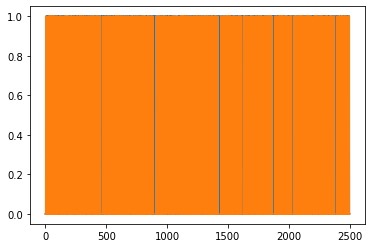

In [78]:
plt.plot(T_test_log)
plt.plot(classes_data_sigmoid)

print("Accuracy: ", 100 - np.mean(np.abs(T_test_log - classes_data_sigmoid)) * 100, "%")

In [79]:
#Cross validation for Non-linear logistic regression
def crossValidation_logistic_sigmoid(folds, X):
    XTrain, XTest, Train, TTest = split(X[:,:-1],X[:,-1:])
    number = int(XTrain.shape[0] / folds)
    param_grid = [{'optim': ['scg'], '_lambda': [.001, .01, .1, 1]} ]       # Making different combination of Hyperparameters
    grid = list(ParameterGrid(param_grid))  # Generating the list all possible combinations of hyperparameters
    
    hiddenUnits = [5, 10, XTrain.shape[1], 15, 20]
    
    arr_cv = []
    arr_test = []
    final_param = []
    test_index = []
    bestUnits = []
    for i in range(folds):
        print("     *********************Started the ",i+1," fold*************************\n      ")
        
        lower = number*i
        upper = number*(i+1)
        X_test, T_test = XTrain[lower:upper, :], Train[lower:upper, :] # Creating 1st fold as our test data
        XTrain_rem, Train_rem = np.delete(XTrain, np.s_[lower:upper], axis= 0), np.delete(Train, np.s_[lower:upper], axis= 0) #Deleting the test part and assogning the remaining part 
        
        grid_index = []
        arr_cv = []
        hunits = []
        for j in range(folds-1): # Iterating over next four folds and splitting for validation and training data
            low = number*j
            high = number*(j+1)
            X_validate, T_validate = XTrain_rem[low:high, :], Train_rem[low:high, :]
            XTrain_cv, Train_cv = np.delete(XTrain_rem, np.s_[low:high], axis= 0), np.delete(Train_rem, np.s_[low:high], axis= 0)
            
            for k in range(len(grid)): # Iterating over all the combnations of hyperparameters
                for units in range(len(hiddenUnits)):
                    nn_cv = NeuralNetLogRegSigmoid([XTrain.shape[1], hiddenUnits[units], Train.shape[1]+1])
                    nn_cv.train(XTrain_cv, Train_cv, **grid[k])
                    ypred_cv, G = nn_cv.use(X_validate)
                    arr_cv.append(np.mean(np.abs(T_validate - ypred_cv) * 100))
                    grid_index.append(k)
                    hunits.append(hiddenUnits[units])
                
        #print("********Validation Errors from ",i+1," fold********* \n")
        #print(arr_cv)
        minimum = arr_cv.index(max(arr_cv)) # Getting the index of minimum errors from array 
        min_index = grid_index[minimum] # Storing that index of best hyperparam. 
        best_hunit = hunits[minimum]
        print(" Best set of Hyperparameters: ", grid[min_index],"\n")
        print(" Best number of hidden units: ", best_hunit,"\n")
        
        
        #for index in range(len(grid_index)): # Iterating over the indices of grid indexes to calculate test errors
        nn_cv = NeuralNetLogRegSigmoid([XTrain.shape[1], best_hunit, Train.shape[1]+1])
        nn_cv.train(XTrain_rem, Train_rem, **grid[min_index])
        ypred_test, G = nn_cv.use(X_test)
        arr_test.append(100 - np.mean(np.abs(T_test - ypred_test) * 100)) # Calculating test accuracy from best parameters from validation sets
        test_index.append(min_index) # Storing the corresponding index from grid_index with rmse
        bestUnits.append(best_hunit)
        print(" Test Accuracy for Test set: ",np.mean(100 - np.abs(T_test - ypred_test) * 100) ,"\n")
            
    #print("**************Test Errors from all the fold***************\n")
    #print(arr_test)
    #minimum_test = arr_test.index(min(arr_test))
    index= arr_test.index(max(arr_test)) # Storing the index of best hyperparameters after running onto all folds test cases.
    final_param = grid[test_index[index]]
    print("\n    Final Hyperparameters are:",final_param, "\n")
    final_units = bestUnits[index]
    print("      Final hidden units are:",final_units, "\n")
    
    nn_cv = NeuralNetLogRegSigmoid([XTrain.shape[1], final_units, Train.shape[1]+1])
    nn_cv.train(XTrain, Train, **final_param)
    ypred, G = nn_cv.use(XTest)
    
    print("      Final Accuracy after 5-fold cross validation: ",100 - np.mean(np.abs(TTest - ypred) * 100))
    return TTest, ypred, G


In [80]:
test_sigmoid, Tpredicted_sigmoid, G_sigmoid = crossValidation_logistic_sigmoid(5, forest_covtype_data_binary.values)

     *********************Started the  1  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  15 

 Test Accuracy for Test set:  51.266666666666666 

     *********************Started the  2  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  5 

 Test Accuracy for Test set:  49.75555555555555 

     *********************Started the  3  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.01, 'optim': 'scg'} 

 Best number of hidden units:  12 

 Test Accuracy for Test set:  48.84444444444444 

     *********************Started the  4  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  10 

 Test Accuracy for Test set:  51.044444444444444 

     *********************Started the  5  fold**********************

## 3. Implementation of both algorithms from ReLu function

In [81]:
class NeuralNetReLu(NeuralNet):
    '''
        We are defining a new class for calculating results for non-linear regression using ReLu function.
        We are inheriting NeurelNet and make changes only in the forward function where it is using activation function.
    '''
    
    def _init_(self,nunits):
        NeuralNet._init_(self,nunits)
    
   
    def ReLU(self,x):
        return np.maximum(x,0)

    def forward(self,X):
        t = X 
        Z = []

        for i in range(self._nLayers):
            Z.append(t) 
            if i == self._nLayers - 1:
                t = np.dot(self.add_ones(t), self._W[i])
            else:
                t = self.ReLU(np.dot(self.add_ones(t), self._W[i]))
        return (t, Z)

In [82]:
nn_ReLu = NeuralNetReLu([X_train.shape[1], 3, T_train.shape[1]]) 
nn_ReLu.train(X_train, T_train)
t_pred_ReLu = nn_ReLu.use(X_test)
print(np.sqrt(np.mean((T_test - t_pred_ReLu)**2)))

120.79314041745776


In [83]:

# Cross validation for sigmoid non-linear regression
def crossValidation_ReLu(folds, X):
    XTrain, XTest, TTrain, TTest = split(X[:,:-1],X[:,-1:])
    number = int(XTrain.shape[0] / folds)
    
    param_grid = [{'optim': ['scg'], '_lambda': [.001, .01, .1, 1]} ]       # Making different combination of Hyperparameters
    grid = list(ParameterGrid(param_grid))  # Generating the list all possible combinations of hyperparameters
    
    hiddenUnits = [5, 10, XTrain.shape[1], 15, 20]
    
    arr_cv = []
    arr_test = []
    final_param = []
    test_index = []
    bestUnits = []
    for i in range(folds):
        print("     *********************Started the ",i+1," fold*************************\n      ")
        
        lower = number*i
        upper = number*(i+1)
        X_test, T_test = XTrain[lower:upper, :], TTrain[lower:upper, :] # Creating 1st fold as our test data
        XTrain_rem, TTrain_rem = np.delete(XTrain, np.s_[lower:upper], axis= 0), np.delete(TTrain, np.s_[lower:upper], axis= 0) #Deleting the test part and assogning the remaining part 
        
        grid_index = []
        arr_cv = []
        hunits = []
        for j in range(folds-1): # Iterating over next four folds and splitting for validation and training data
            low = number*j
            high = number*(j+1)
            X_validate, T_validate = XTrain_rem[low:high, :], TTrain_rem[low:high, :]
            XTrain_cv, TTrain_cv = np.delete(XTrain_rem, np.s_[low:high], axis= 0), np.delete(TTrain_rem, np.s_[low:high], axis= 0)
            
            for k in range(len(grid)): # Iteratinng over all the combnations of hyperparameters
                for units in range(len(hiddenUnits)):
                    nn_cv = NeuralNetReLu([XTrain.shape[1], hiddenUnits[units], TTrain.shape[1]])
                    nn_cv.train(XTrain_cv, TTrain_cv, **grid[k])
                    ypred_cv = nn_cv.use(X_validate)
                    arr_cv.append(np.sqrt(np.mean((T_validate - ypred_cv)**2)))
                    grid_index.append(k)
                    hunits.append(hiddenUnits[units])
                
        #print("********Validation Errors from ",i+1," fold********* \n")
        #print(arr_cv)
        minimum = arr_cv.index(min(arr_cv)) # Getting the index of minimum errors from array 
        min_index = grid_index[minimum] # Storing that index of best hyperparam. 
        best_hunit = hunits[minimum]
        print(" Best Hyperparameters: ", grid[min_index])
        print(" Best number of hidden units: ", best_hunit)
        
        
        #for index in range(len(grid_index)): # Iterating over the indices of grid indexes to calculate test errors
        nn_cv = NeuralNetReLu([XTrain.shape[1], best_hunit, TTrain.shape[1]])
        nn_cv.train(XTrain_rem, TTrain_rem, **grid[min_index])
        ypred_test = nn_cv.use(X_test)
        arr_test.append(np.sqrt(np.mean((T_test - ypred_test)**2))) # Calculating test error from best parameters from validation sets
        test_index.append(min_index) # Storing the corresponding index from grid_index with rmse
        bestUnits.append(best_hunit)
        print(" RMSE value for this test set: ",np.sqrt(np.mean((T_test - ypred_test)**2)))
            
    #print("**************Test Errors from all the fold***************\n")
    #print(arr_test)
    #minimum_test = arr_test.index(min(arr_test))
    index= arr_test.index(min(arr_test)) # Storing the index of best hyperparameters after running onto all folds test cases.
    final_param = grid[test_index[index]]
    print("            \nFinal Hyperparameters are: ",final_param)
    final_units = bestUnits[index]
    print("              Final hidden units are: ",final_units)
    
    nn_cv = NeuralNetReLu([XTrain.shape[1], final_units, TTrain.shape[1]])
    nn_cv.train(XTrain, TTrain, **final_param)
    ypred = nn_cv.use(XTest)
    
    print("              Final RMSE after 5-fold cross validation: ",np.sqrt(np.mean((TTest - ypred)**2)))
    return TTest, ypred


In [84]:
testSet_ReLu, tPred_ReLu = crossValidation_ReLu(5, df_regression_new.values)

     *********************Started the  1  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.1, 'optim': 'scg'}
 Best number of hidden units:  10
 RMSE value for this test set:  128.8949132688296
     *********************Started the  2  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  53
 RMSE value for this test set:  120.17835967039562
     *********************Started the  3  fold*************************
      
 Best Hyperparameters:  {'_lambda': 1, 'optim': 'scg'}
 Best number of hidden units:  15
 RMSE value for this test set:  133.50794332982025
     *********************Started the  4  fold*************************
      
 Best Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'}
 Best number of hidden units:  15
 RMSE value for this test set:  136.01208193370115
     *********************Started the  5  fold*************************
      
 Best Hyperparameters:  {'_lambda': 

#### Non_linear logistic regression using ReLu function

In [85]:
from nn import NeuralNet

class NeuralNetLogRegReLu(NeuralNetLogReg):
    """ Nonlinear Logistic Regression
    """

    def __init__(self, nunits):
        super().__init__(nunits)
 
    def ReLu(self,x):
        return np.maximum(x,0)

    def forward(self,X):
        t = X 
        Z = []

        for i in range(self._nLayers):
            Z.append(t) 
            if i == self._nLayers - 1:
                t = np.dot(self.add_ones(t), self._W[i])
            else:
                t = self.ReLu(np.dot(self.add_ones(t), self._W[i]))
        return self.softmax(t), Z

In [86]:
logistic_data_ReLu = NeuralNetLogRegReLu([X_train_log.shape[1], 6, number_classes])

logistic_data_ReLu.train(X_train_log, T_train_log)
classes_data_ReLu, prob_ReLu = logistic_data_ReLu.use(X_test_log)

Accuracy:  51.64 %


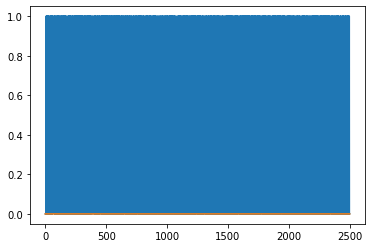

In [87]:
plt.plot(T_test_log)
plt.plot(classes_data_ReLu)

print("Accuracy: ", 100 - np.mean(np.abs(T_test_log - classes_data_ReLu)) * 100, "%")

In [88]:
#Cross validation for Non-linear logistic regression
def crossValidation_logistic_ReLu(folds, X):
    XTrain, XTest, Train, TTest = split(X[:,:-1],X[:,-1:])
    number = int(XTrain.shape[0] / folds)
    param_grid = [{'optim': ['scg'], '_lambda': [.001, .01, .1, 1]} ] # Making different combination of Hyperparameters
    grid = list(ParameterGrid(param_grid))  # Generating the list all possible combinations of hyperparameters
    
    hiddenUnits = [5, 10, XTrain.shape[1], 15, 20]
    
    arr_cv = []
    arr_test = []
    final_param = []
    test_index = []
    bestUnits = []
    for i in range(folds):
        print("     *********************Started the ",i+1," fold*************************\n      ")
        
        lower = number*i
        upper = number*(i+1)
        X_test, T_test = XTrain[lower:upper, :], Train[lower:upper, :] # Creating 1st fold as our test data
        XTrain_rem, Train_rem = np.delete(XTrain, np.s_[lower:upper], axis= 0), np.delete(Train, np.s_[lower:upper], axis= 0) #Deleting the test part and assogning the remaining part 
        
        grid_index = []
        arr_cv = []
        hunits = []
        for j in range(folds-1): # Iterating over next four folds and splitting for validation and training data
            low = number*j
            high = number*(j+1)
            X_validate, T_validate = XTrain_rem[low:high, :], Train_rem[low:high, :]
            XTrain_cv, Train_cv = np.delete(XTrain_rem, np.s_[low:high], axis= 0), np.delete(Train_rem, np.s_[low:high], axis= 0)
            
            for k in range(len(grid)): # Iterating over all the combnations of hyperparameters
                for units in range(len(hiddenUnits)):
                    nn_cv = NeuralNetLogRegReLu([XTrain.shape[1], hiddenUnits[units], Train.shape[1]+1])
                    nn_cv.train(XTrain_cv, Train_cv, **grid[k])
                    ypred_cv, G = nn_cv.use(X_validate)
                    arr_cv.append(100 - np.mean(np.abs(T_validate - ypred_cv) * 100))
                    grid_index.append(k)
                    hunits.append(hiddenUnits[units])

        minimum = arr_cv.index(max(arr_cv)) # Getting the index of minimum errors from array 
        min_index = grid_index[minimum] # Storing that index of best hyperparam. 
        best_hunit = hunits[minimum]
        print(" Best set of Hyperparameters: ", grid[min_index],"\n")
        print(" Best number of hidden units: ", best_hunit,"\n")
        
        
        nn_cv = NeuralNetLogRegReLu([XTrain.shape[1], best_hunit, Train.shape[1]+1])
        nn_cv.train(XTrain_rem, Train_rem, **grid[min_index])
        ypred_test, G = nn_cv.use(X_test)
        arr_test.append(100 - np.mean(np.abs(T_test - ypred_test) * 100)) # Calculating test error from best parameters from validation sets
        test_index.append(min_index) # Storing the corresponding index from grid_index with rmse
        bestUnits.append(best_hunit)
        print(" Test Accuracy for Test set: ",np.mean(np.abs(T_test - ypred_test) * 100) ,"\n")
            
    index= arr_test.index(max(arr_test)) # Storing the index of best hyperparameters after running onto all folds test cases.
    final_param = grid[test_index[index]]
    print("\n    Final Hyperparameters are:",final_param, "\n")
    final_units = bestUnits[index]
    print("      Final hidden units are:",final_units, "\n")
    
    nn_cv = NeuralNetLogRegReLu([XTrain.shape[1], final_units, Train.shape[1]+1])
    nn_cv.train(XTrain, Train, **final_param)
    ypred, G = nn_cv.use(XTest)
    
    print("      Final Accuracy after 5-fold cross validation: ",100 - np.mean(np.abs(TTest - ypred) * 100))
    return TTest, ypred, G

In [89]:
test_ReLu, Tpredicted_ReLu, G_ReLu = crossValidation_logistic_ReLu(5, forest_covtype_data_binary.values)

     *********************Started the  1  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  5 

 Test Accuracy for Test set:  50.98642962962963 

     *********************Started the  2  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  10 

 Test Accuracy for Test set:  48.55555555555556 

     *********************Started the  3  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  5 

 Test Accuracy for Test set:  49.644444444444446 

     *********************Started the  4  fold*************************
      
 Best set of Hyperparameters:  {'_lambda': 0.001, 'optim': 'scg'} 

 Best number of hidden units:  10 

 Test Accuracy for Test set:  50.17777777777778 

     *********************Started the  5  fold***********************

### Summary of Activation Functions

#### Nonlinear Regression

Here are the effects of RMSE errors when running various activation functions for templates. After running a 5-fold cross validation for each model, these errors are obtained.

<table style="width:50%">
  <tr>
    <th>Sigmoid</th>
    <th>Hyperbolic Tangent</th> 
    <th>ReLU</th>
  </tr>
  <tr>
    <td>106.24312996841242</td>
    <td>73.77268064241602</td> 
    <td>120.79314041745776</td>
</table>

#### Nonlinear Logistic regression

Here are the results of Optimum Precision while running with multiple activation functions for templates. This accuracies are obtained for each model after running a 5-fold cross-validation

<table style="width:50%">
  <tr>
    <th>Sigmoid</th>
    <th>Hyperbolic Tangent</th> 
    <th>ReLU</th>
  </tr>
  <tr>
    <td>50.972192</td>
    <td>51.186048</td> 
    <td>51.64</td>
</table>

# Conclusion

Number of key and current concepts in our workbook that we have studied and implemented

1. **Cross Validation**: One of the most critical and reliable methods of resolving the question of model overfitting and underfitting. We break our knowledge into test and train set(further split into another train and test set(called validation set)). Simple concept. This way, we train and test the amount of times our data and most importantly, the best outcome from each category of information. Finally, test our model on entirely fresh knowledge that has never been applied to our model.

    In our implementation, we have trained our models on different set of hyperparameters to get the best results.
    

2. **Neural Networks**: By application, we have discovered in this workbook how 2 layered neural networks work. As part of our introduction, we have introduced 2 big supervised learning strategies (Regression and Classification): 

    - Regression in Non-Linear. 
    - Logistic Non-Linear Regression. 
    
   Our regression and classification dataset are applied fully and by cross-validation. We also found that we can achieve improved results/accuracy after tuning with distinct hyperparameters using cross validation. If we try on for different and more parameter values, this can be strengthened further. Due to computing time, we kept the numbers smaller.
   
3. **Activation Functions**: The main explanation for the non-linearity of our model is activation functions. On all of our algorithms, we have studied and evaluated three major activation functions. 
    - Sigmoid Function.
    - Hyperbolic Tangent.
    - ReLu
    
    We evaluated the results by cross-validating and tuning hyperparameters as well as operating directly on the entire dataset. We note that with our tuning parameters, Hyperbolic Tangent performs well on our regression dataset, while sigmoid outperforms all those with parameters we checked on in the classification dataset. These effects are not predetermined and which vary on various datasets and most notably, with the variance in the testing of hyperparameters.
  

# Reference


Pace, R. Kelley and Ronald Barry, 'Sparse Spatial Autoregressions, Statistics and Probability Letters, https://www.kaggle.com/harrywang/housing/home

Hunter, J. D. "Matplotlib: A 2D graphics environment",Computing In Science & Engineering, IEEE COMPUTER SOC, 9, 90-95 (2007), https://matplotlib.org/tutorials/introductory/sample_plots.html

Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006), http://www.numpy.org/

Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010), http://pandas.pydata.org/pandas-docs/version/0.15.2/generated/pandas.DataFrame.replace.html

Aurélien Géron, "Hands on Machine learning with scikit learn and Tensorflow", O'Reilly Media, 2017